# 0.0 Imports

In [73]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import sweetviz          as sv
import xgboost           as xgb
import inflection
import warnings
warnings.filterwarnings('ignore')

from matplotlib              import pyplot    as plt
from scipy                   import stats     as ss
from sklearn                 import ensemble  as en
from sklearn                 import neighbors as nh
from boruta                  import BorutaPy
from tabulate                import tabulate
from IPython.core.display    import HTML
from sklearn.svm             import SVC
from skopt                   import gp_minimize
from sklearn.metrics         import roc_auc_score, precision_score, recall_score, confusion_matrix
from IPython.display         import Image
from sklearn.preprocessing   import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental    import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import f1_score
from scikitplot.metrics      import plot_cumulative_gain, plot_lift_curve, plot_ks_statistic, plot_calibration_curve, plot_confusion_matrix 
from sklearn.linear_model    import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.datasets        import make_classification
from yellowbrick.classifier  import ClassPredictionError, ROCAUC, PrecisionRecallCurve, ConfusionMatrix

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1) / (n - 1))
    
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (k - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

def ml_acc( model_name, y, yhat ):
    acc = accuracy_score( y, yhat )
    f1 = f1_score( y, yhat )
    recall = recall_score(y, yhat) 
    precision = precision_score(y, yhat) 
    
    return pd.DataFrame( { 'Model Name': model_name,
                            'Accuracy': acc,
                            'f1_score': f1,
                            'Recall': recall,
                            'Precision': precision}, index=[0] )

def cross_validation(model_name, model, x_train, y_train, k, verbose=False):
    '''Função para realizar o Cross Validation dos modelos de Machine Learning'''
    precision_k_list = []
    recall_k_list    = []
    
    kfolds = StratifiedKFold(n_splits = 5, shuffle=True, random_state=5)
    
    for cv_train, cv_val in kfolds.split(x_train, y_train):
        
        # Cross-Validation Train
        xtrain_val = x_train.iloc[cv_train]
        ytrain_val = y_train.iloc[cv_train]
        
        # Cross-Validation Validation
        xval = x_train.iloc[cv_val]
        yval = y_train.iloc[cv_val]
        
        # Treinamento do modelo
        model.fit(xtrain_val, ytrain_val)

        # Previsão
        yhat_prob  = model.predict_proba(xval)
        yhat       = model.predict(xval)
        
        # Preparando os Dados
        data = xval.copy()
        data['response'] = yval.copy()

        # Score
        data['score'] = yhat_prob[:, 1].tolist()

        data = data.sort_values('score', ascending = False)

        # Performance
        precision_k = precision_at_k(data, k)
        precision_k_list.append(precision_k)
        
        recall_k = recall_at_k(data, k)
        recall_k_list.append(recall_k)
        
        acc = accuracy_score(yval, yhat)
        
    return pd.DataFrame({'Precision @k - CV': np.round(np.mean(precision_k_list), 3),
                         'Recall @k - CV': np.round(np.mean(recall_k_list), 3),
                         'Accuracy - CV': np.round(np.mean(acc), 3)},index=[model_name])

def treinar_modelo_rfc(params):
    max_depth = params[0]
    print(params, '\n')
    

    mdl = RandomForestClassifier(max_depth=max_depth, n_estimators=600, random_state=42)

    mdl.fit(X_train, y_train)

    p = mdl.predict_proba(X_test)[:, 1]

    return -roc_auc_score(y_test, p)

def precision_at_k(data, k=2000):
    '''Função para calcular o precision @ k do modelo'''
    data = data.reset_index(drop=True)
    
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

def recall_at_k(data, k=2000):
    '''Função para calcular a recall @ k do modelo'''
    data = data.reset_index(drop=True)
    
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_raw = pd.read_csv('../data/raw/churn.csv', low_memory=False)

In [5]:
df_raw.sample()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7614,7615,15725002,Smith,749,France,Male,37,7,0.0,2,1,0,20306.79,0


# 1.0 Data Description

In [6]:
# Cópia para otimização
df1 = df_raw.copy()

- RowNumber: Número total de colunas do dataset
- CustomerID: Identificador único do cliente
- Surname: Último nome do cliente
- CreditScore: Score do cartão do cliente 
- Geography: Localidade ( País ) do cliente
- Gender: Gênero do cliente
- Age: Idade do cliente
- Tenure: Quantidade de anos que o cliente contrata serviços com o banco 
- Balance: Saldo atual do cliente em sua conta no banco
- NumOfProducts: Quantidade de produtos que o cliente comprou 
- HasCrCard: Se o cliente possui ( 1 ) cartão de crédito ou não ( 0 ) 
- IsActiveMember: Se o cliente é ativo ( Nos últimos 12 meses ) 
- EstimateSalary: Salário anual estimado do cliente
- Exited: Se o cliente entrou em churn ( 1 ) ou não ( 0 )

## 1.1 Rename Columns

In [7]:
old_cols = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

snake_case = lambda x: inflection.underscore(x)

new_cols = list( map(snake_case, old_cols))
df1.columns = new_cols

## 1.2 Data Dimensions

In [8]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 10000
Number of columns: 14


## 1.3 Data Types

In [9]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Check NA 

In [10]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Fillout NA 

- There's no NA data in this dataset

## 1.6 Change Types

- There's no data to change in this dataset

## 1.7 Descriptive Statistical

In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'])

### 1.7.1 Numerical Attributes

In [12]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, max, min, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.00,10000.00,9999.00,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,customer_id,15565701.00,15815690.00,249989.00,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,credit_score,350.00,850.00,500.00,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,age,18.00,92.00,74.00,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,tenure,0.00,10.00,10.00,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,balance,0.00,250898.09,250898.09,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,num_of_products,1.00,4.00,3.00,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,has_cr_card,0.00,1.00,1.00,7.055000e-01,1.000000e+00,0.455818,-0.901812,-1.186973
8,is_active_member,0.00,1.00,1.00,5.151000e-01,1.000000e+00,0.499772,-0.060437,-1.996747
9,estimated_salary,11.58,199992.48,199980.90,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518


<AxesSubplot:xlabel='estimated_salary'>

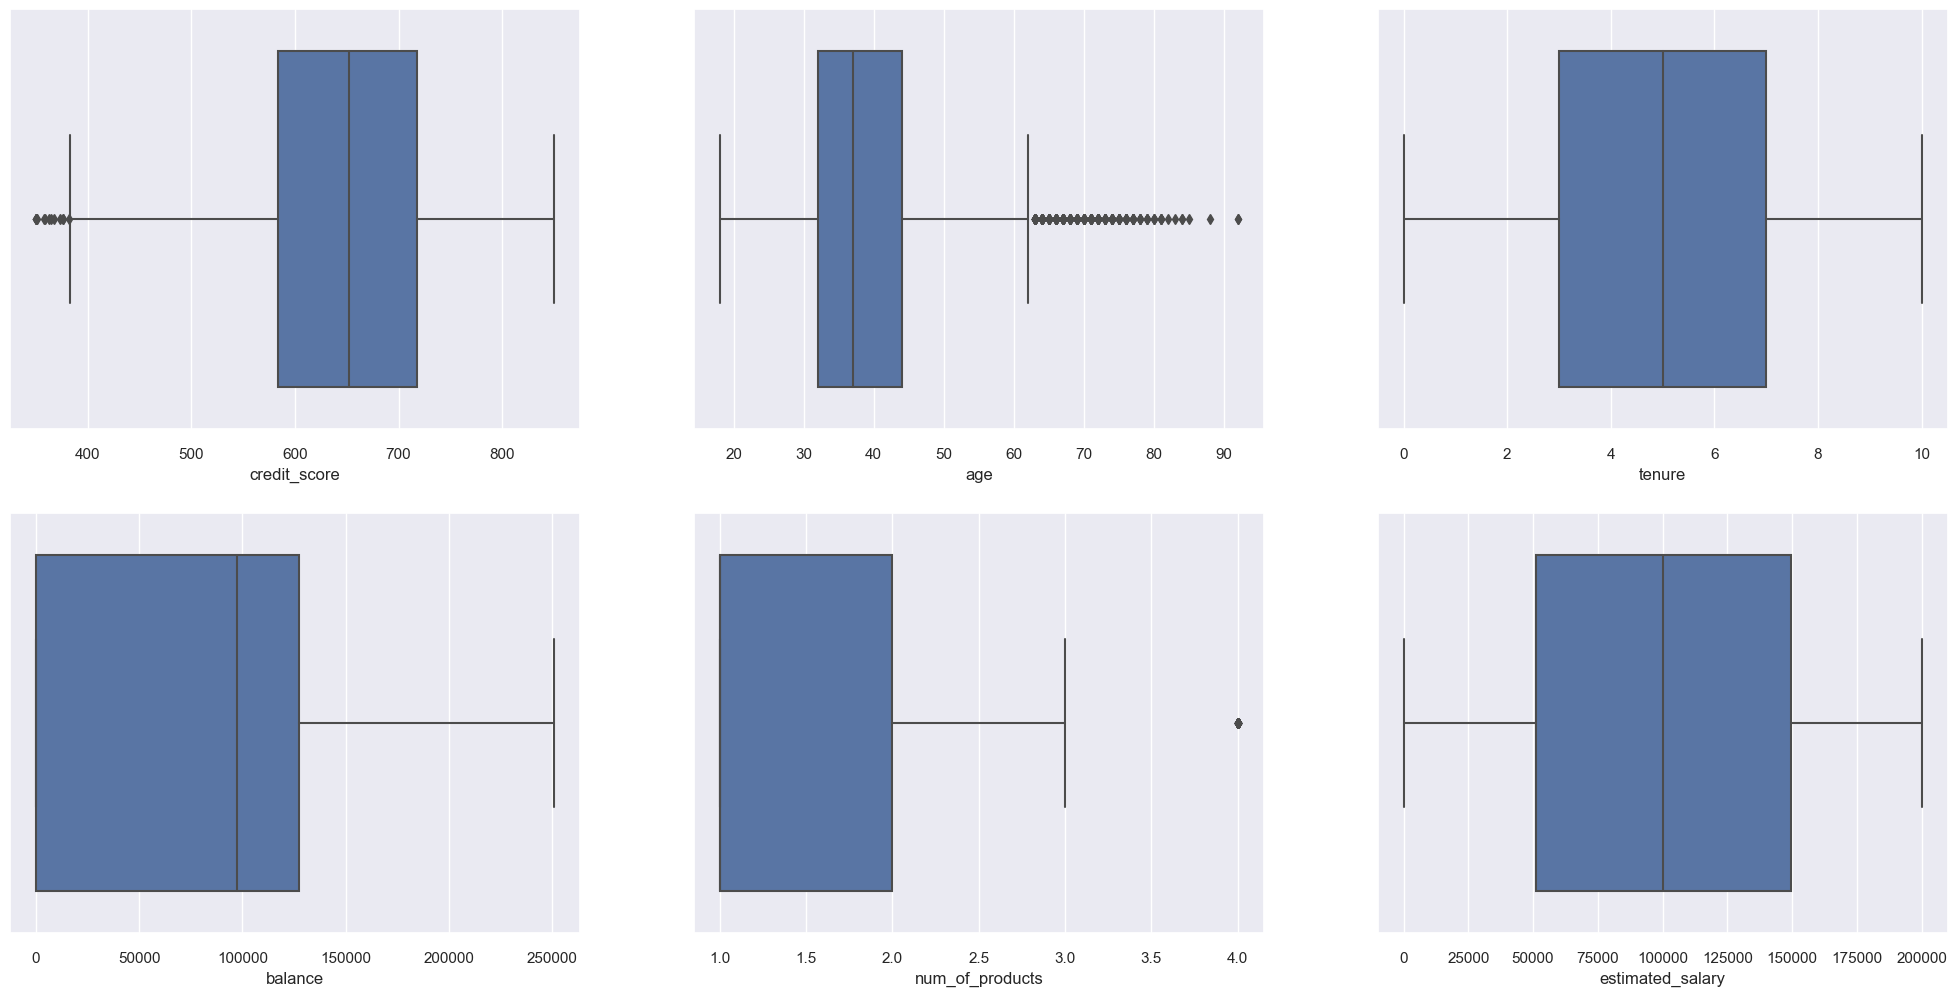

In [13]:
# Análise das variáveis numéricas no boxplot
plt.subplot(2, 3, 1)
sns.boxplot(x='credit_score', data=num_attributes)

plt.subplot(2, 3, 2)
sns.boxplot(x='age', data=num_attributes)

plt.subplot(2, 3, 3)
sns.boxplot(x='tenure', data=num_attributes)

plt.subplot(2, 3, 4)
sns.boxplot(x='balance', data=num_attributes)

plt.subplot(2, 3, 5)
sns.boxplot(x='num_of_products', data=num_attributes)

plt.subplot(2, 3, 6)
sns.boxplot(x='estimated_salary', data=num_attributes)

### 1.7.2 Categorical Attributes

In [14]:
# Quantas variáveis categóricas em cada feature
cat_attributes.apply( lambda x: x.unique().shape[0] )

surname      2932
geography       3
gender          2
dtype: int64

In [15]:
# Quais variáveis
cat_attributes.apply( lambda x: x.unique() )

surname      [Hargrave, Hill, Onio, Boni, Mitchell, Chu, Ba...
geography                             [France, Spain, Germany]
gender                                          [Female, Male]
dtype: object

<AxesSubplot:xlabel='gender', ylabel='exited'>

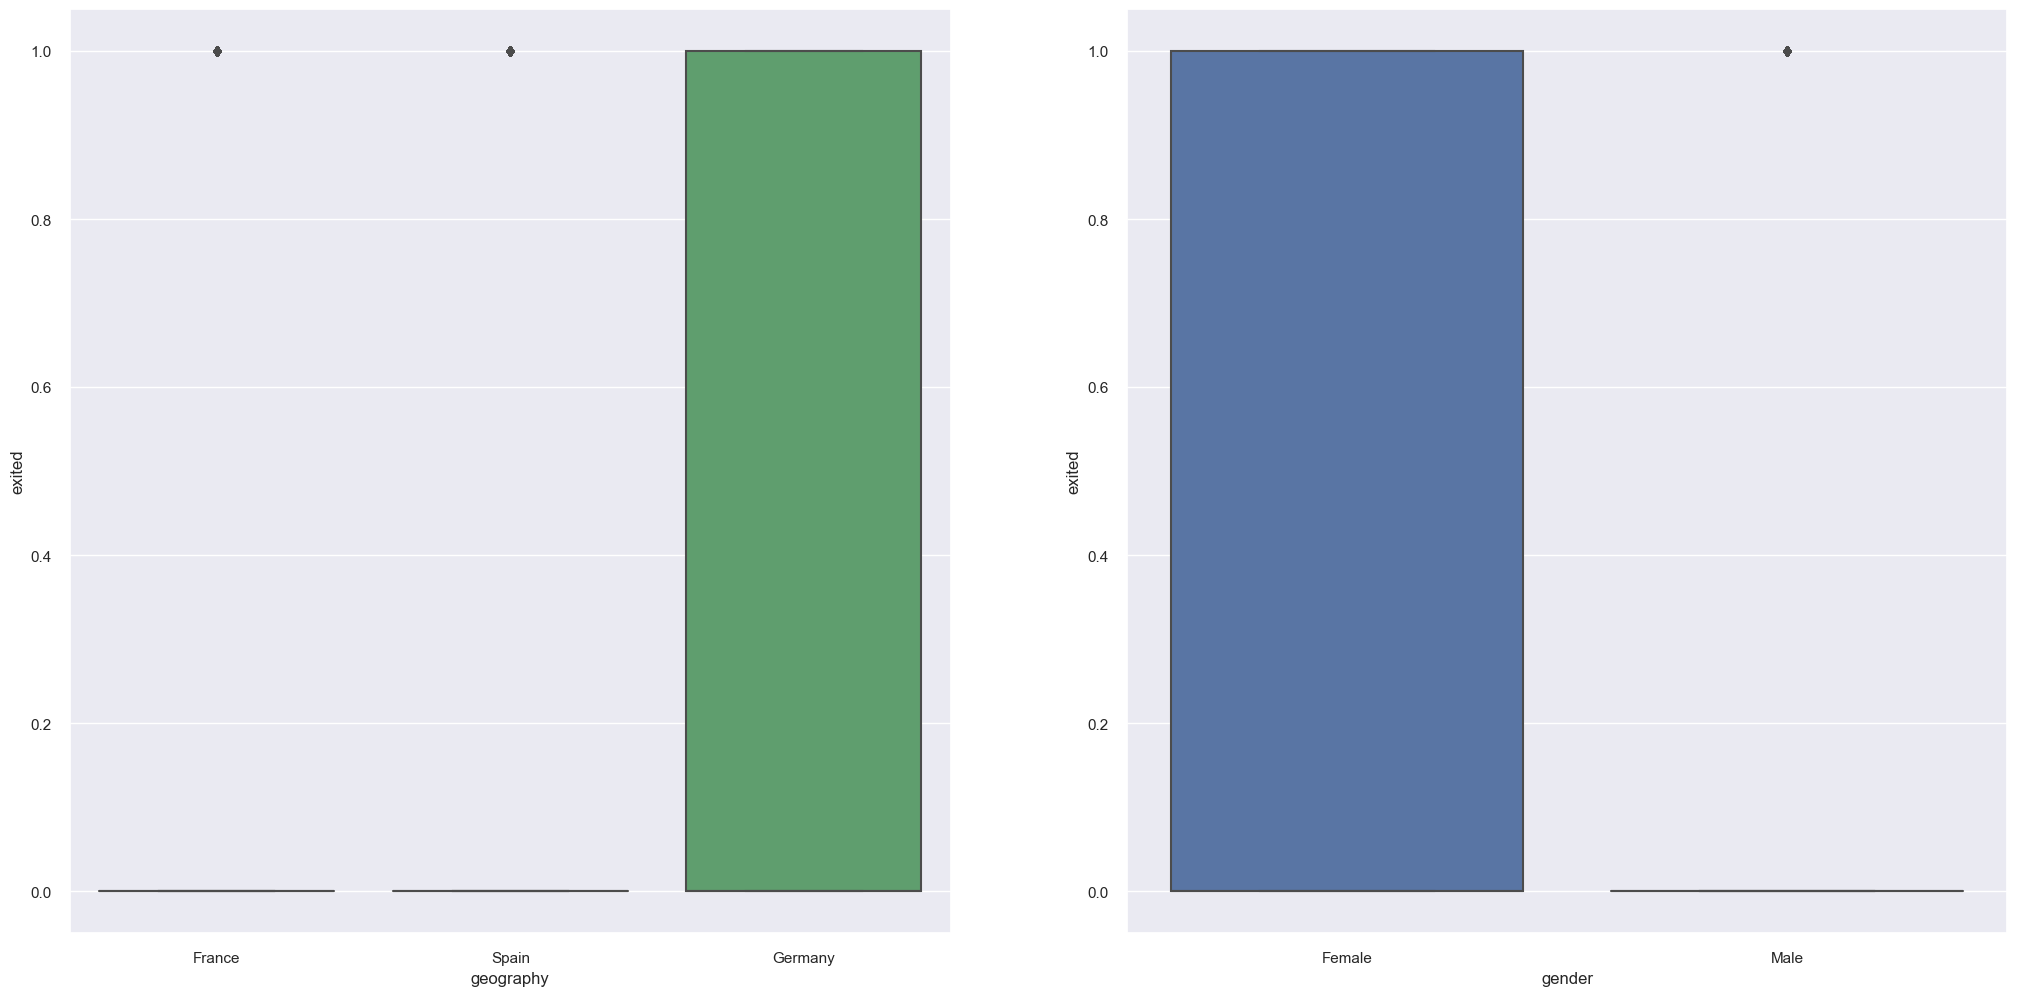

In [16]:
# Ignoring surname column
plt.subplot(1, 2, 1)
sns.boxplot(x='geography', y='exited', data=df1)

plt.subplot(1, 2, 2)
sns.boxplot(x='gender', y='exited', data=df1)

# 2.0 Feature Engineering

In [17]:
df2 = df1.copy()

## 2.1 MindMap Hypothesis

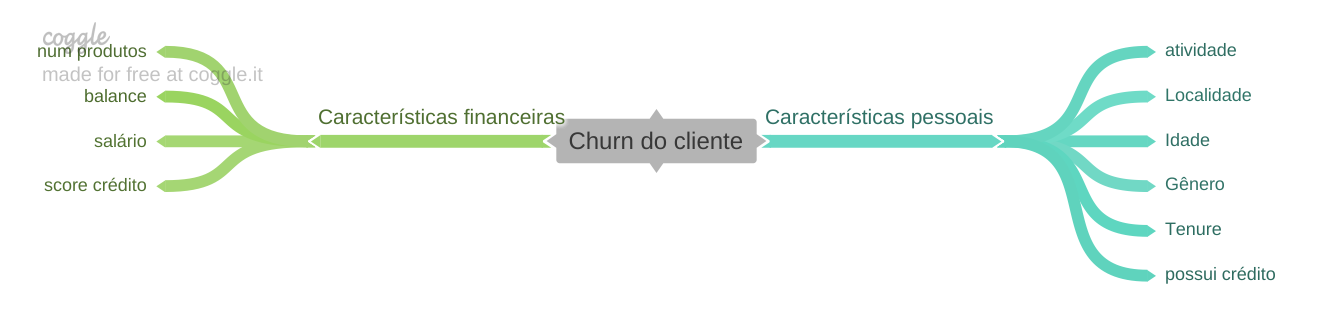

In [18]:
Image('../reports/figures/mind_map_churn.png')

## 2.2 Creating Hypothesis

### 2.2.1 Hipóteses Características Pessoais

- 1.A atividade do cliente influencia em possível churn?
- 2.A localidade do cliente influencia em possível churn?
- 3.A idade do cliente influencia em possível churn?
- 4.O gênero do cliente influencia em possível churn?
- 5.A tenure do cliente influencia em possível churn?
- 6.O fato do cliente possuir cartão de crédito influencia em possível churn?

### 2.2.2 Hipóteses Características Financeiras

- 1.O salário do cliente influencia em possível churn?
- 2.O score do cliente influencia em possível churn?
- 3.O número de produtos comprados pelo cliente influencia em possível churn?
- 4.O balanço financeiro do cliente influencia em possível churn?

## 2.3 Final List of Hypothesis

- 1.O salário do cliente influencia em possível churn?
- 2.O balanço financeiro do cliente influencia em possível churn?
- 3.A idade do cliente influencia em possível churn?
- 4.A tenure do cliente influencia em possível churn?
- 5.O score do cliente influencia em possível churn?
- 6.O número de produtos comprados pelo cliente influencia em possível churn?

## 2.4 Feature Engineering

In [19]:
# High Age Feature - Tendem a realizar o churn mais facilmente
df2['high_age'] = df2['age'].apply(lambda x: 1 if x > 48 else 0)

# Medium Balance Feature - Tendem a realizar o churn mais facilmente
df2['medium_balance'] = df2['balance'].apply(lambda x: 1 if 100000.00 < x < 150000.00 else 0)

# Null Balance Feature - Tendem a não realizar o churn de forma significativa
df2['null_balance'] = df2['balance'].apply(lambda x: 1 if x == 0 else 0)

# Number of Products Feature
df2['low_products'] = df2['num_of_products'].apply(lambda x: 1 if x == 1 or x == 2 else 0)
df2['high_products'] = df2['num_of_products'].apply(lambda x: 1 if x == 3 or x == 4 else 0)

# Estimated Monthly Salary Feature
df2['estimated_monthly_salary'] = df2['estimated_salary'].apply(lambda x: x / 12)

# 3.0 Filtragem de Variáveis

In [20]:
df3 = df2.copy()

In [21]:
df3.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,high_age,medium_balance,null_balance,low_products,high_products,estimated_monthly_salary
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,0,1,1,0,8445.740000
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,0,1,0,9378.548333
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0,0,0,0,1,9494.297500
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0,1,1,0,7818.885833
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0,6590.341667


## 3.1 Filtragem de linhas 

- Sem linhas para filtrar

## 3.2 Filtragem de colunas

In [22]:
cols_drop = ['row_number', 'customer_id', 'surname']

df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise Exploratória de Dados

In [23]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

<AxesSubplot:xlabel='exited', ylabel='Density'>

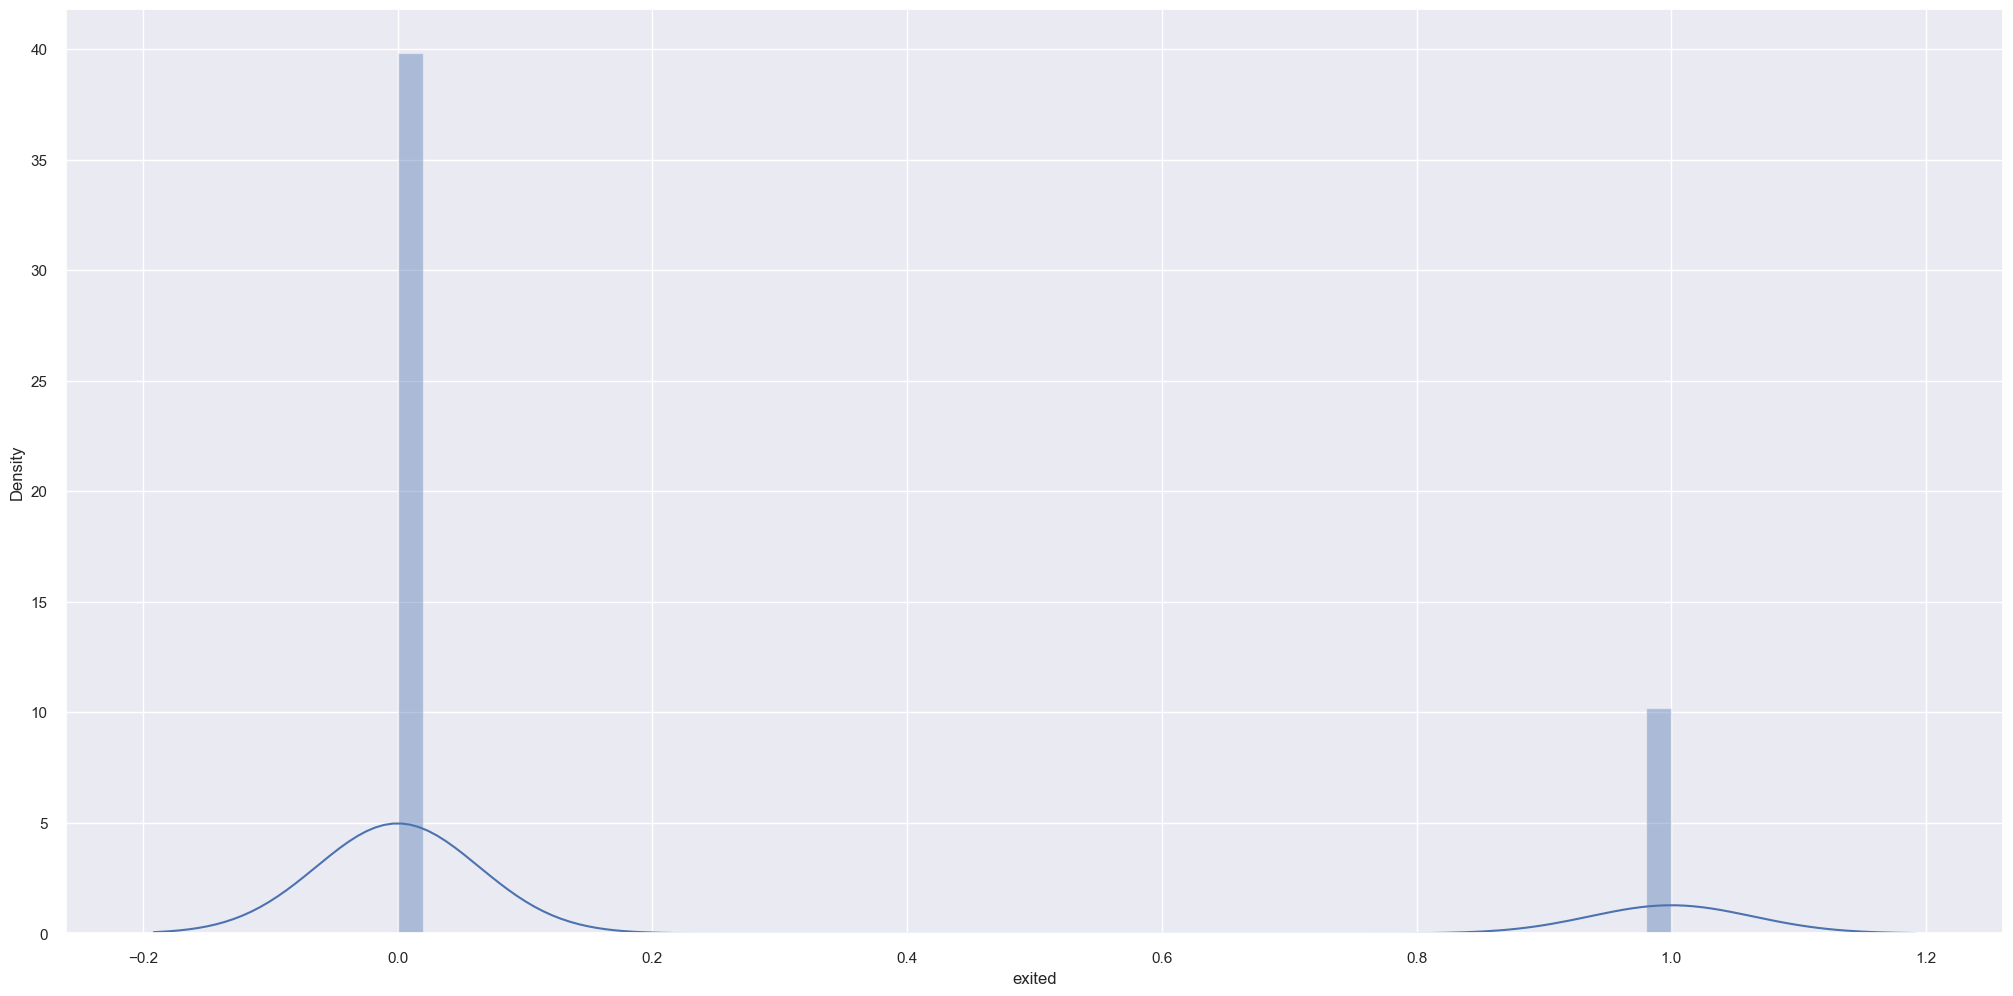

In [24]:
sns.distplot(df4['exited'])

In [ ]:
# Taxa de Churn atual da empresa
df4['exited'].value_counts(normalize=True)*100 

### 4.1.2 Numerical Variable

array([[<AxesSubplot:title={'center':'row_number'}>,
        <AxesSubplot:title={'center':'customer_id'}>,
        <AxesSubplot:title={'center':'credit_score'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'balance'}>],
       [<AxesSubplot:title={'center':'num_of_products'}>,
        <AxesSubplot:title={'center':'has_cr_card'}>,
        <AxesSubplot:title={'center':'is_active_member'}>],
       [<AxesSubplot:title={'center':'estimated_salary'}>,
        <AxesSubplot:title={'center':'exited'}>, <AxesSubplot:>]],
      dtype=object)

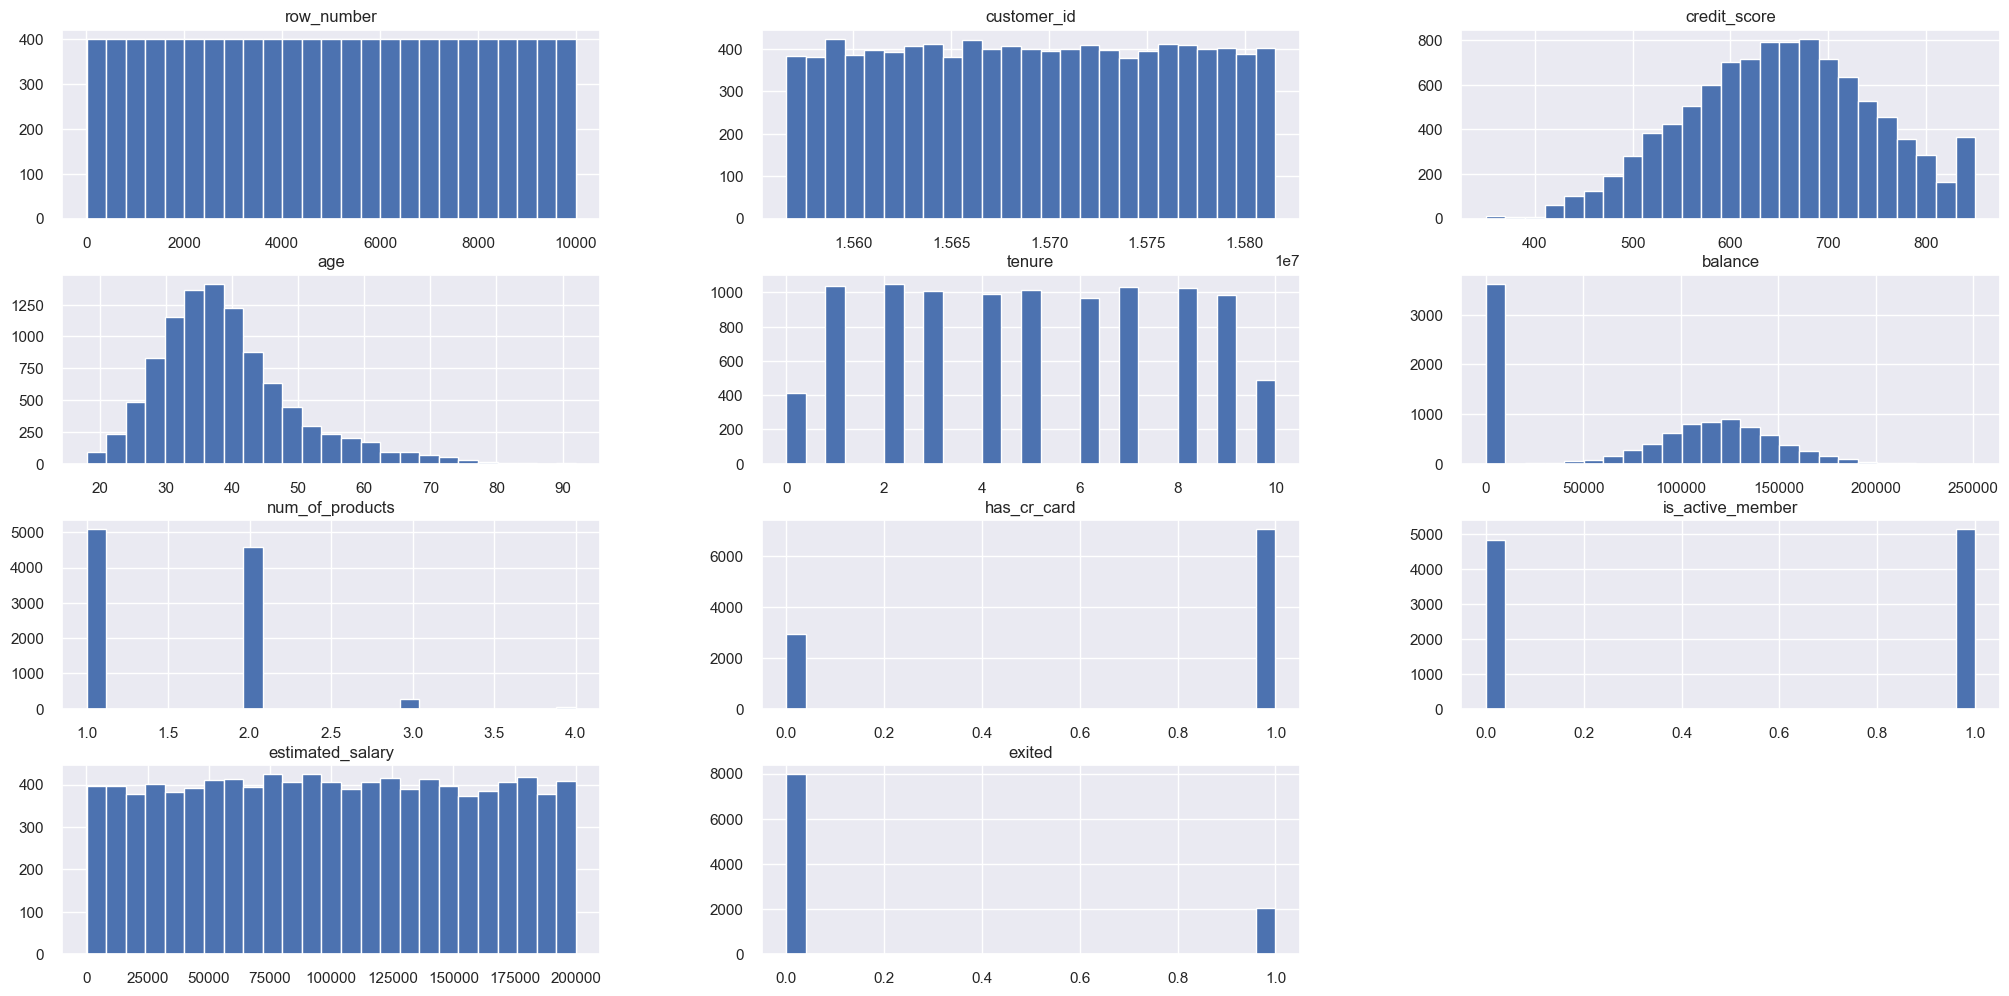

In [25]:
num_attributes.hist(bins=25)

### 4.1.3 Categorical Variable

In [ ]:
# geography
plt.subplot( 2, 2, 1 )
sns.countplot( df4['geography'] )

plt.subplot( 2, 2, 2 )
sns.kdeplot( df4[df4['geography'] == 'France']['exited'], label='France', shade=True )
sns.kdeplot( df4[df4['geography'] == 'Spain']['exited'], label='Spain', shade=True )
sns.kdeplot( df4[df4['geography'] == 'Germany']['exited'], label='Germany', shade=True )

# gender
plt.subplot( 2, 2, 3 )
sns.countplot( df4['gender'] )

plt.subplot( 2, 2, 4 )
sns.kdeplot( df4[df4['gender'] == 'Female']['exited'], label='Female', shade=True )
sns.kdeplot( df4[df4['gender'] == 'Male']['exited'], label='Male', shade=True )

## 4.2 Análise Bivariada

### H1. O salário do cliente influencia em possível churn?

### VERDADEIRA. O salário influencia de forma leve, porém significativa em um trecho do gráfico. Clientes com os melhores salários estimados anuais tendem a realizar o churn mais facilmente (A partir dos 170k anuais)

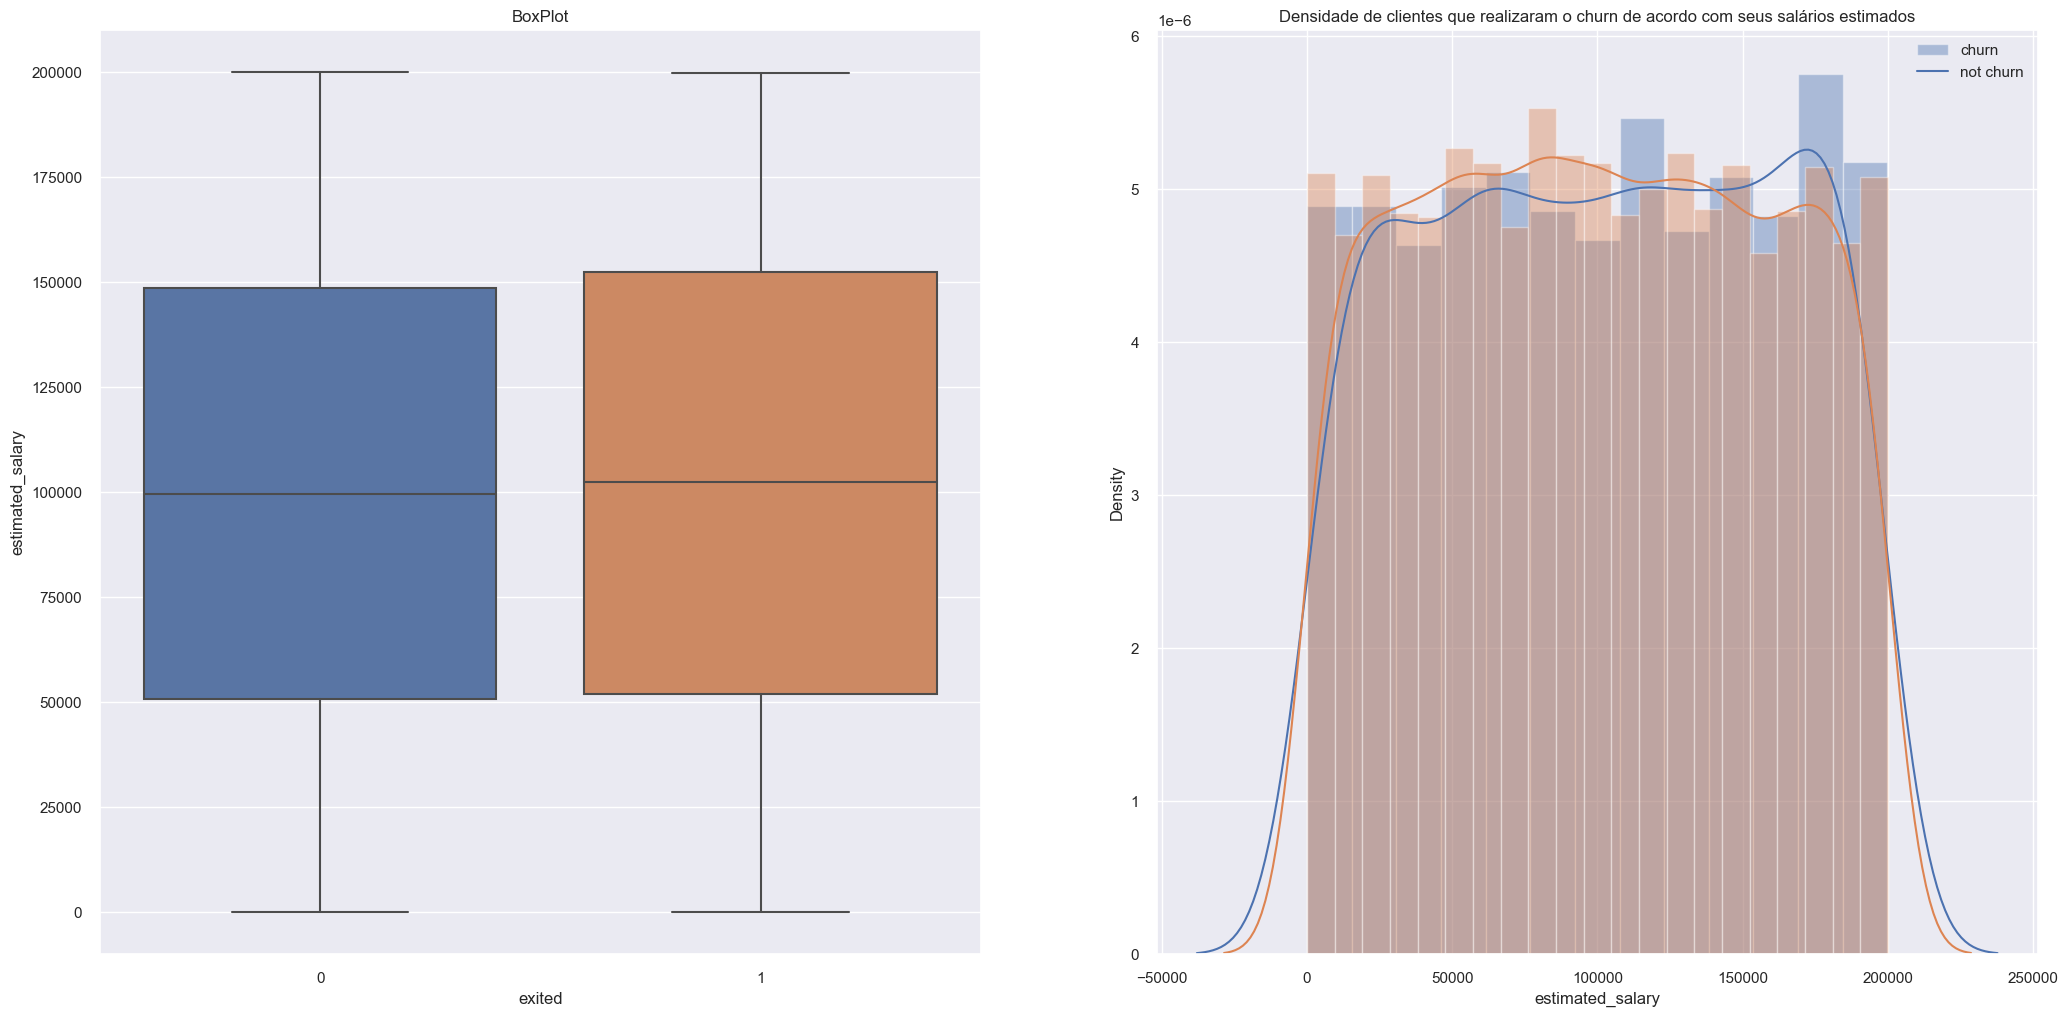

In [26]:
plt.subplot( 1, 2, 1 )
sns.boxplot(x='exited', y='estimated_salary', data=df4).set_title('BoxPlot') ; 

plt.subplot( 1, 2, 2 )
sns.distplot(df4[df4['exited'] == 1]['estimated_salary'], label='churn') 
sns.distplot(df4[df4['exited'] == 0]['estimated_salary'], label='not churn') 
plt.title('Densidade de clientes que realizaram o churn de acordo com seus salários estimados')
plt.legend(['churn', 'not churn']) ;

In [ ]:
table = df4.groupby(['exited', 'is_active_member']).agg('count').balance.unstack()
table

### H2. A quantidade de dinheiro localizada na conta do cliente (Balance) influencia em possível churn?

### VERDADEIRA. A feature Balance influencia de maneira positiva quanto ao churn de cliente, uma vez que percebe-se que na faixa entre 100k e 150k, há a maior tendência de churn, emquanto na faixa nula (0k) há maior tendência de não ocorrer o churn

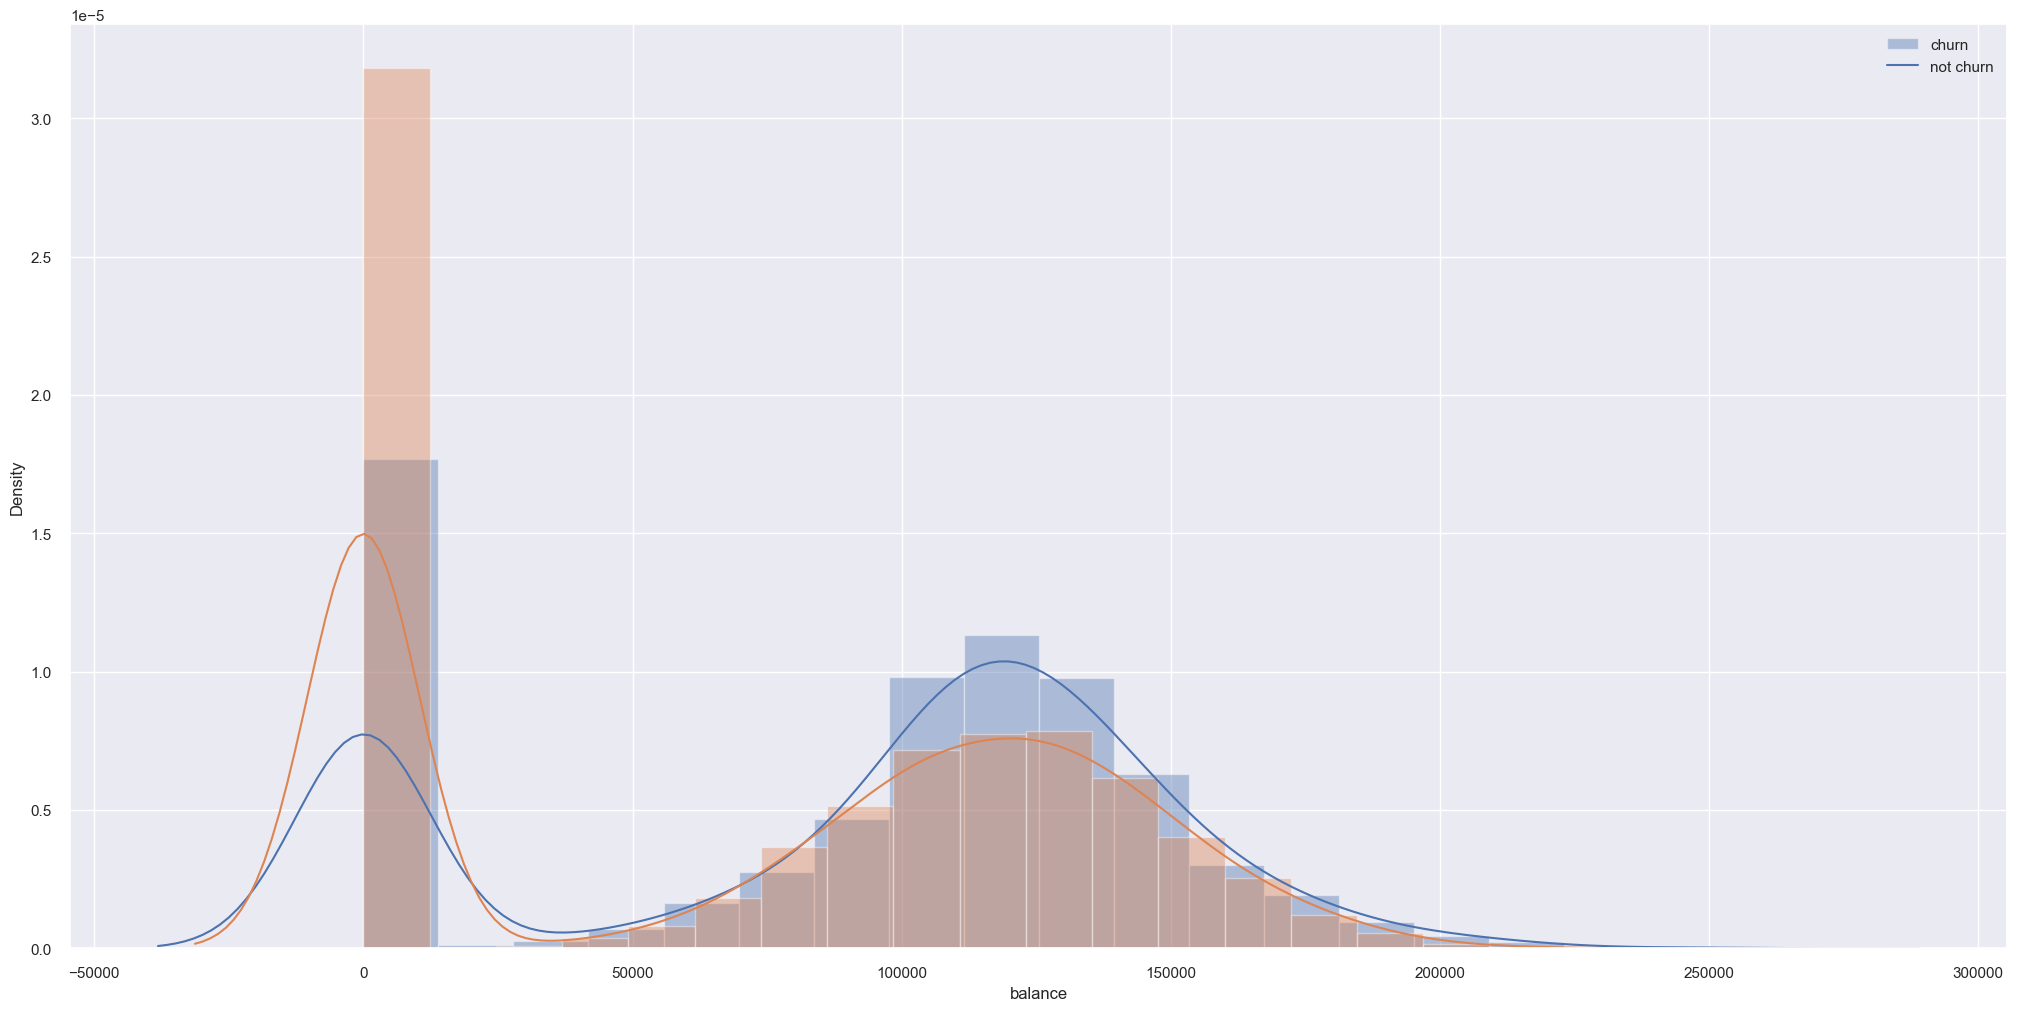

In [27]:
sns.distplot(df4[df4['exited'] == 1]['balance'], label='churn') ;
sns.distplot(df4[df4['exited'] == 0]['balance'], label='not churn') ;
plt.legend(['churn', 'not churn']) ;

### H3. A idade do cliente influencia em possível churn?

### VERDADEIRA. A idade influencia de forma significativa, haja vista que pessoas mais idosas tendem a realizar o churn ( A partir dos 48/49 anos) 

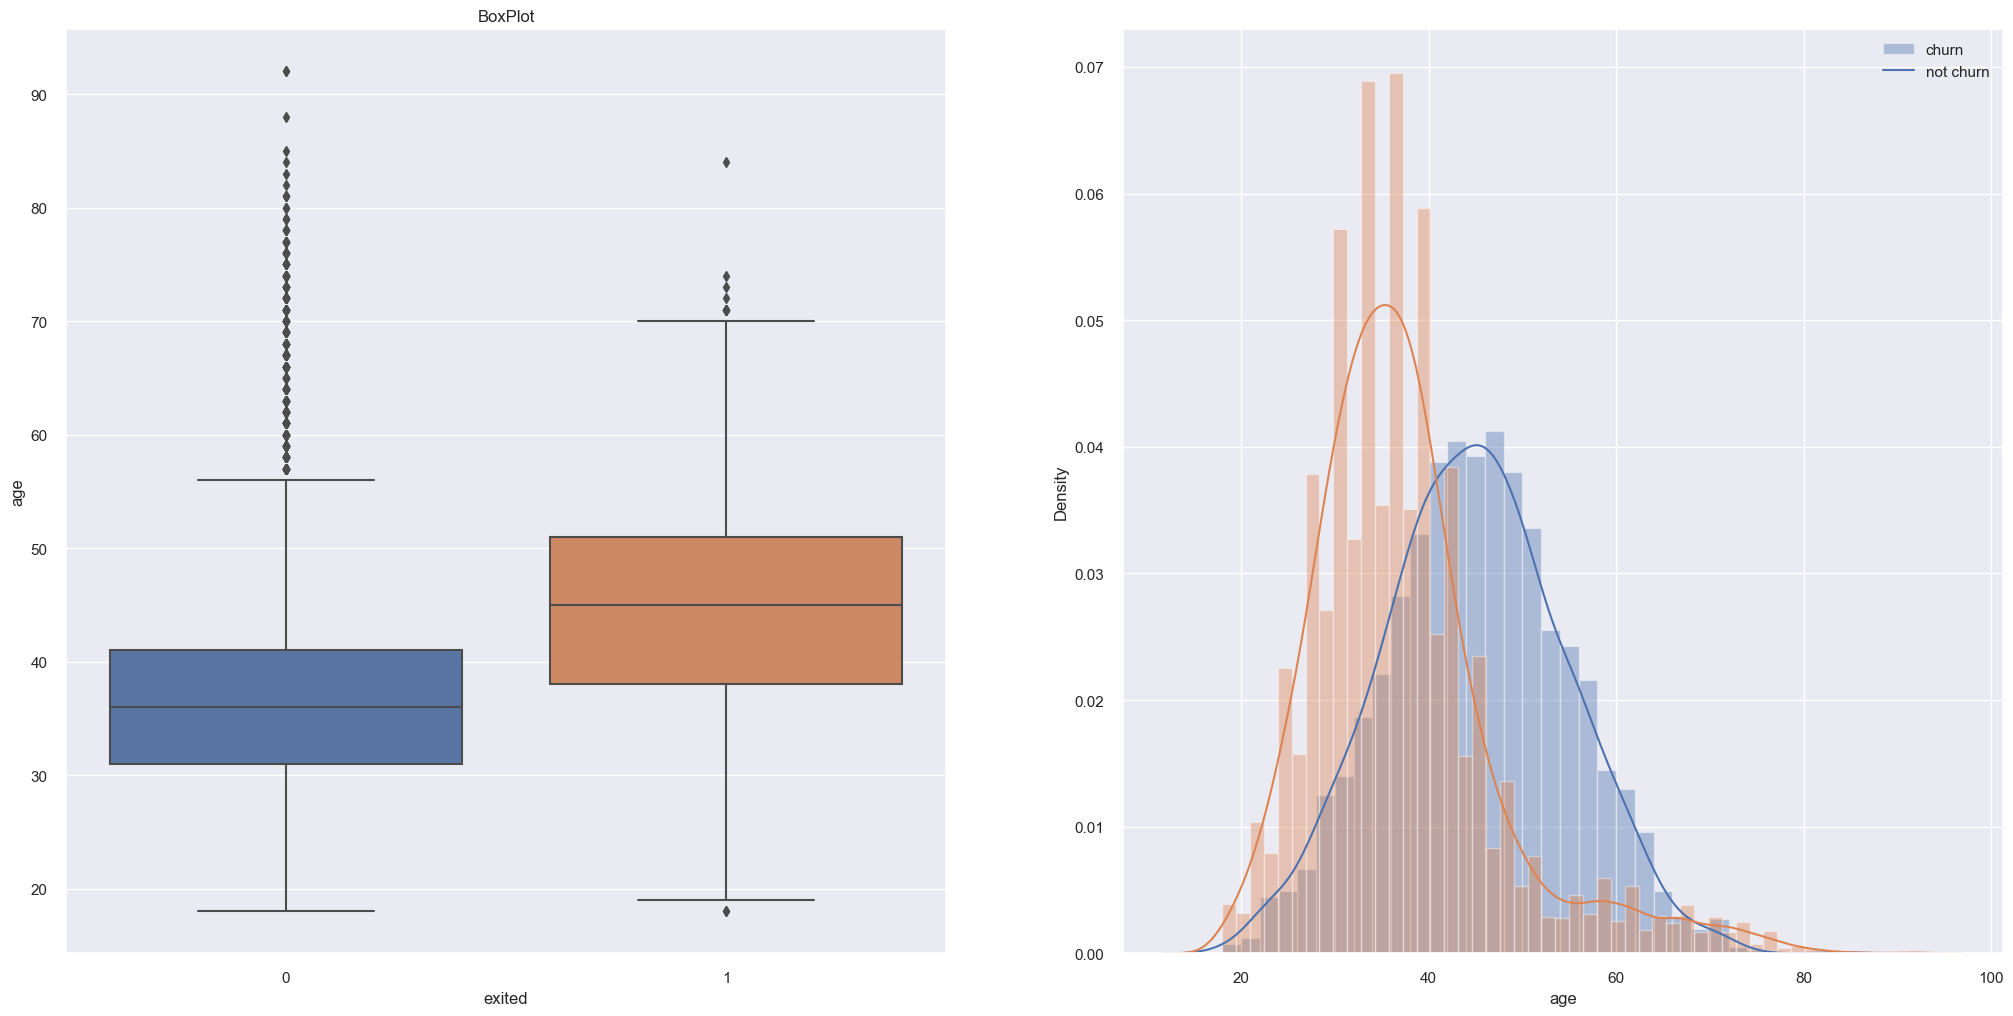

In [28]:
plt.subplot( 1, 2, 1 )
sns.boxplot(x='exited', y='age', data=df4).set_title('BoxPlot') ; 

plt.subplot( 1, 2, 2 )
sns.distplot(df4[df4['exited'] == 1]['age'], label='churn') 
sns.distplot(df4[df4['exited'] == 0]['age'], label='not churn') 
plt.legend(['churn', 'not churn']);

### H4. A tenure do cliente influencia em possível churn?

### VERDADEIRA. Porém, a tenure dos clientes influencia de maneira insuficiente para concluir insights, já que a variação é significativa entre os dados de tenure

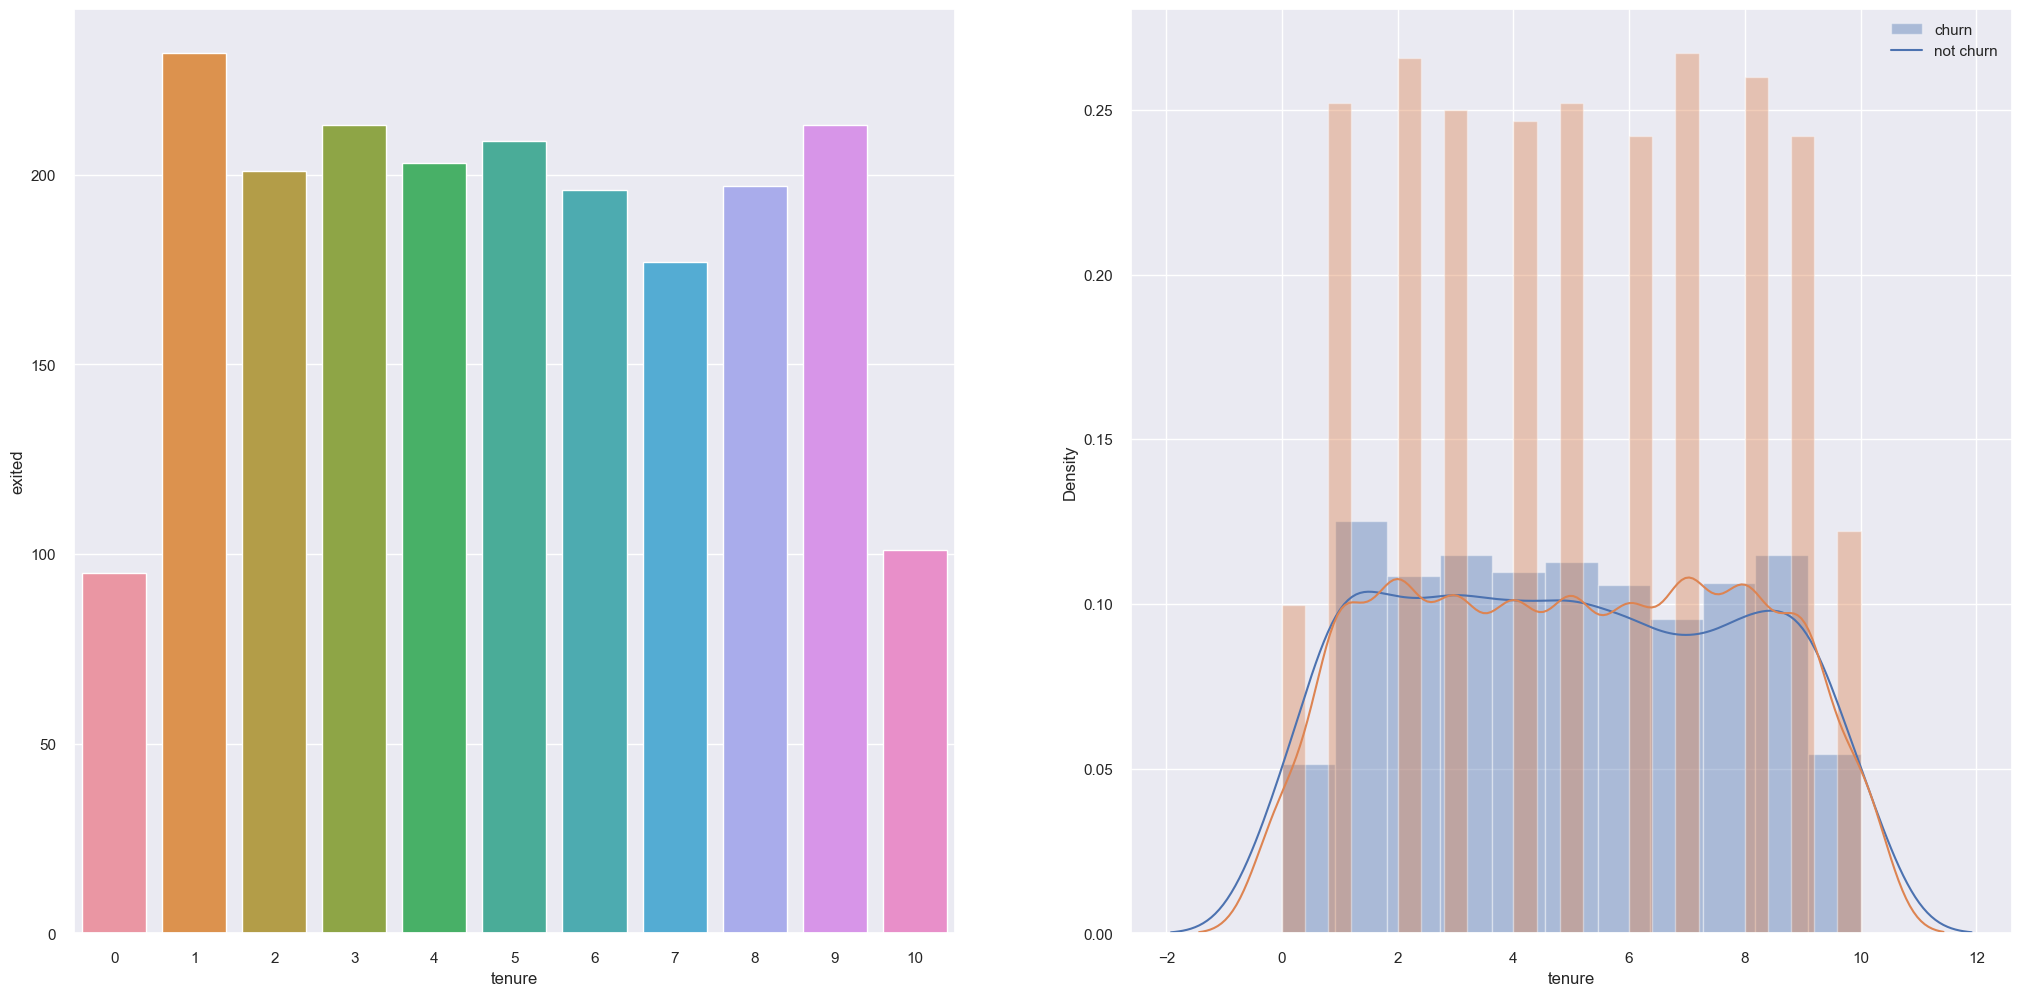

In [29]:
plt.subplot( 1, 2, 1 )
aux1 = df4[['tenure', 'exited']].groupby( 'tenure' ).sum().reset_index()
sns.barplot( x='tenure', y='exited', data=aux1 );

plt.subplot( 1, 2, 2 )
sns.distplot(df4[df4['exited'] == 1]['tenure'], label='churn') 
sns.distplot(df4[df4['exited'] == 0]['tenure'], label='not churn') 
plt.legend(['churn', 'not churn']) ;

### H5. O score do cliente influencia em possível churn?

### FALSA. Não há diferença significativa no churn dos clientes com alto ou baixo score do cartão 

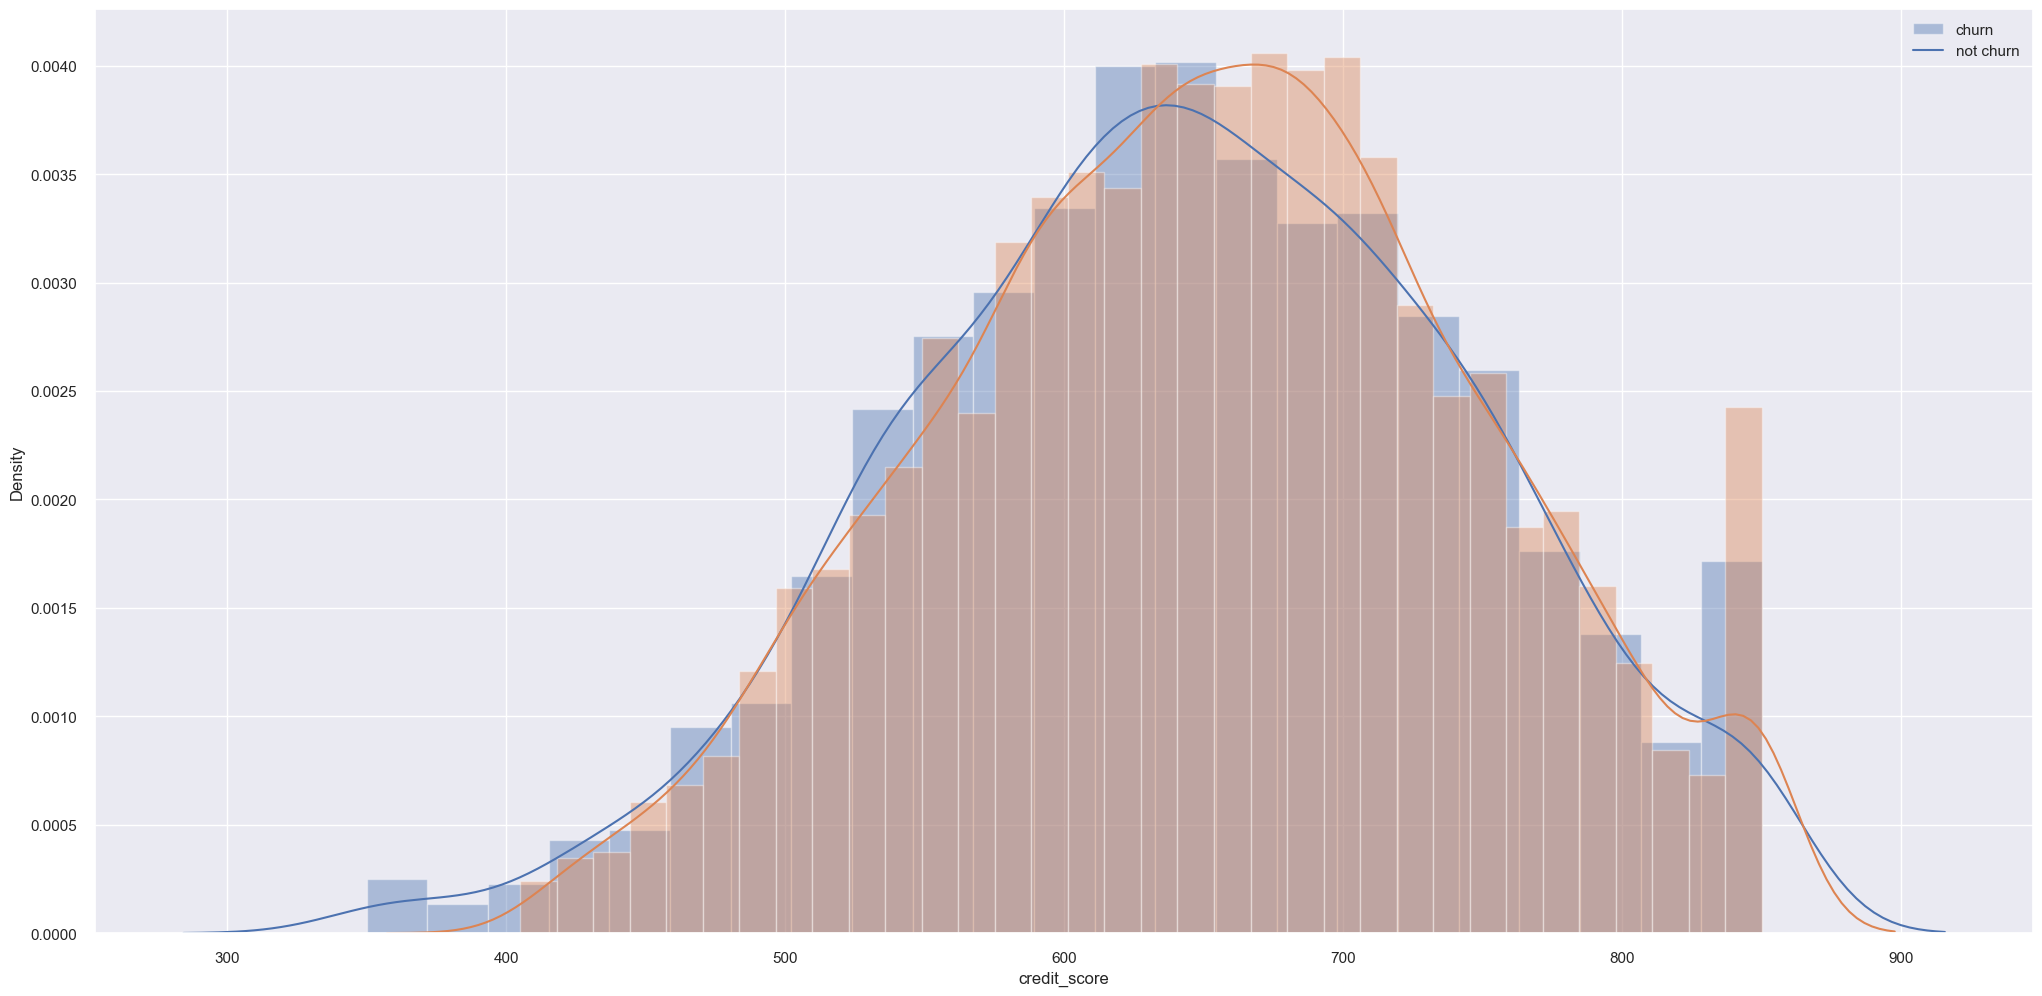

In [30]:
sns.distplot(df4[df4['exited'] == 1]['credit_score'], label='churn')
sns.distplot(df4[df4['exited'] == 0]['credit_score'], label='not churn')
plt.legend(['churn', 'not churn']) ;

### H6. O número de produtos comprados pelo cliente influencia em possível churn?

### VERDADEIRA. O número de produtos influencia em possível churn, haja vista que pessoas com menos produtos tendem a realizar o churn (Churn rate acima da média)

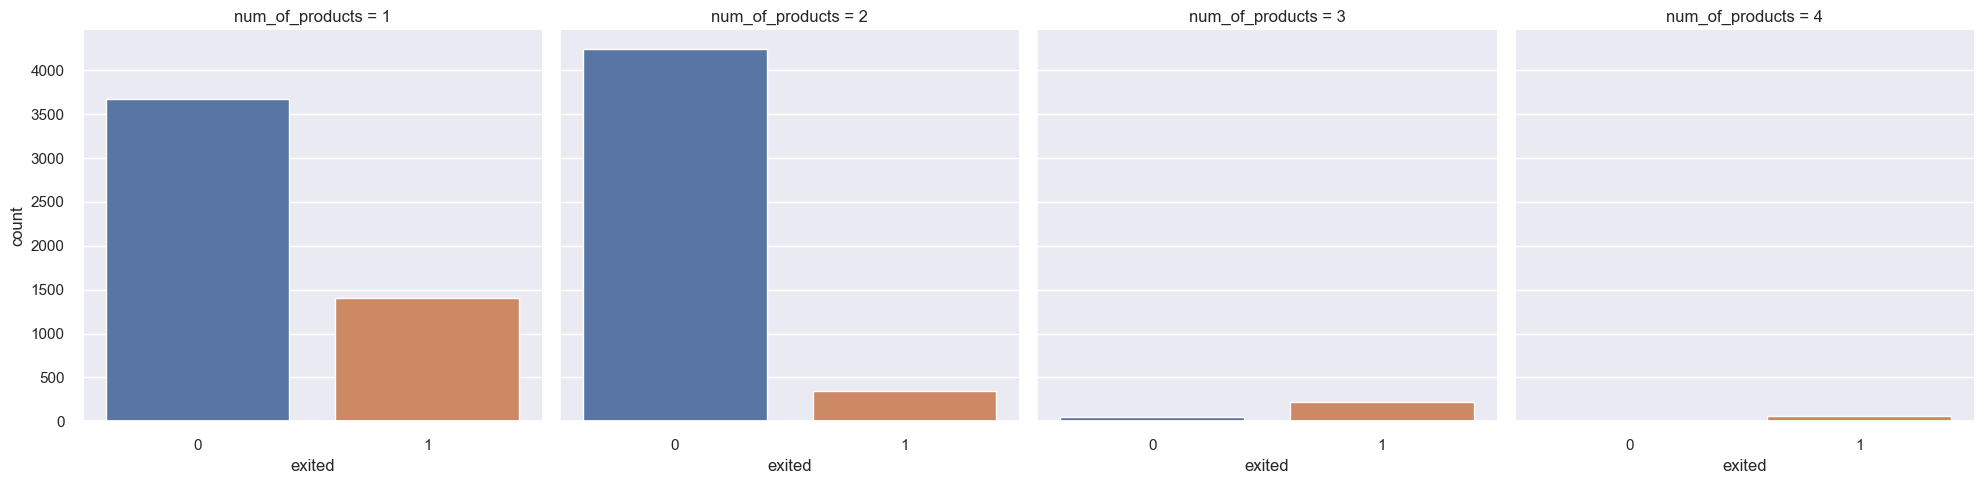

In [31]:
sns.catplot(x='exited', data=df4, kind='count', col='num_of_products', legend=True) ; 

In [ ]:
aux1 = df4[['num_of_products', 'exited']].groupby( 'num_of_products' ).sum().reset_index()
sns.barplot( x='num_of_products', y='exited', data=aux1 );

### 4.2.1 Resumo das Hipóteses

In [32]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Verdadeira', 'Baixa'],
['H2', 'Verdadeira', 'Media'],
['H3', 'Verdadeira', 'Alta'],
['H4', 'Falsa', 'Média'],
['H5', 'Verdadeira', 'Média'],
['H6', 'Verdadeira', 'Alta'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Verdadeira   Media
H3           Verdadeira   Alta
H4           Falsa        Média
H5           Verdadeira   Média
H6           Verdadeira   Alta


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

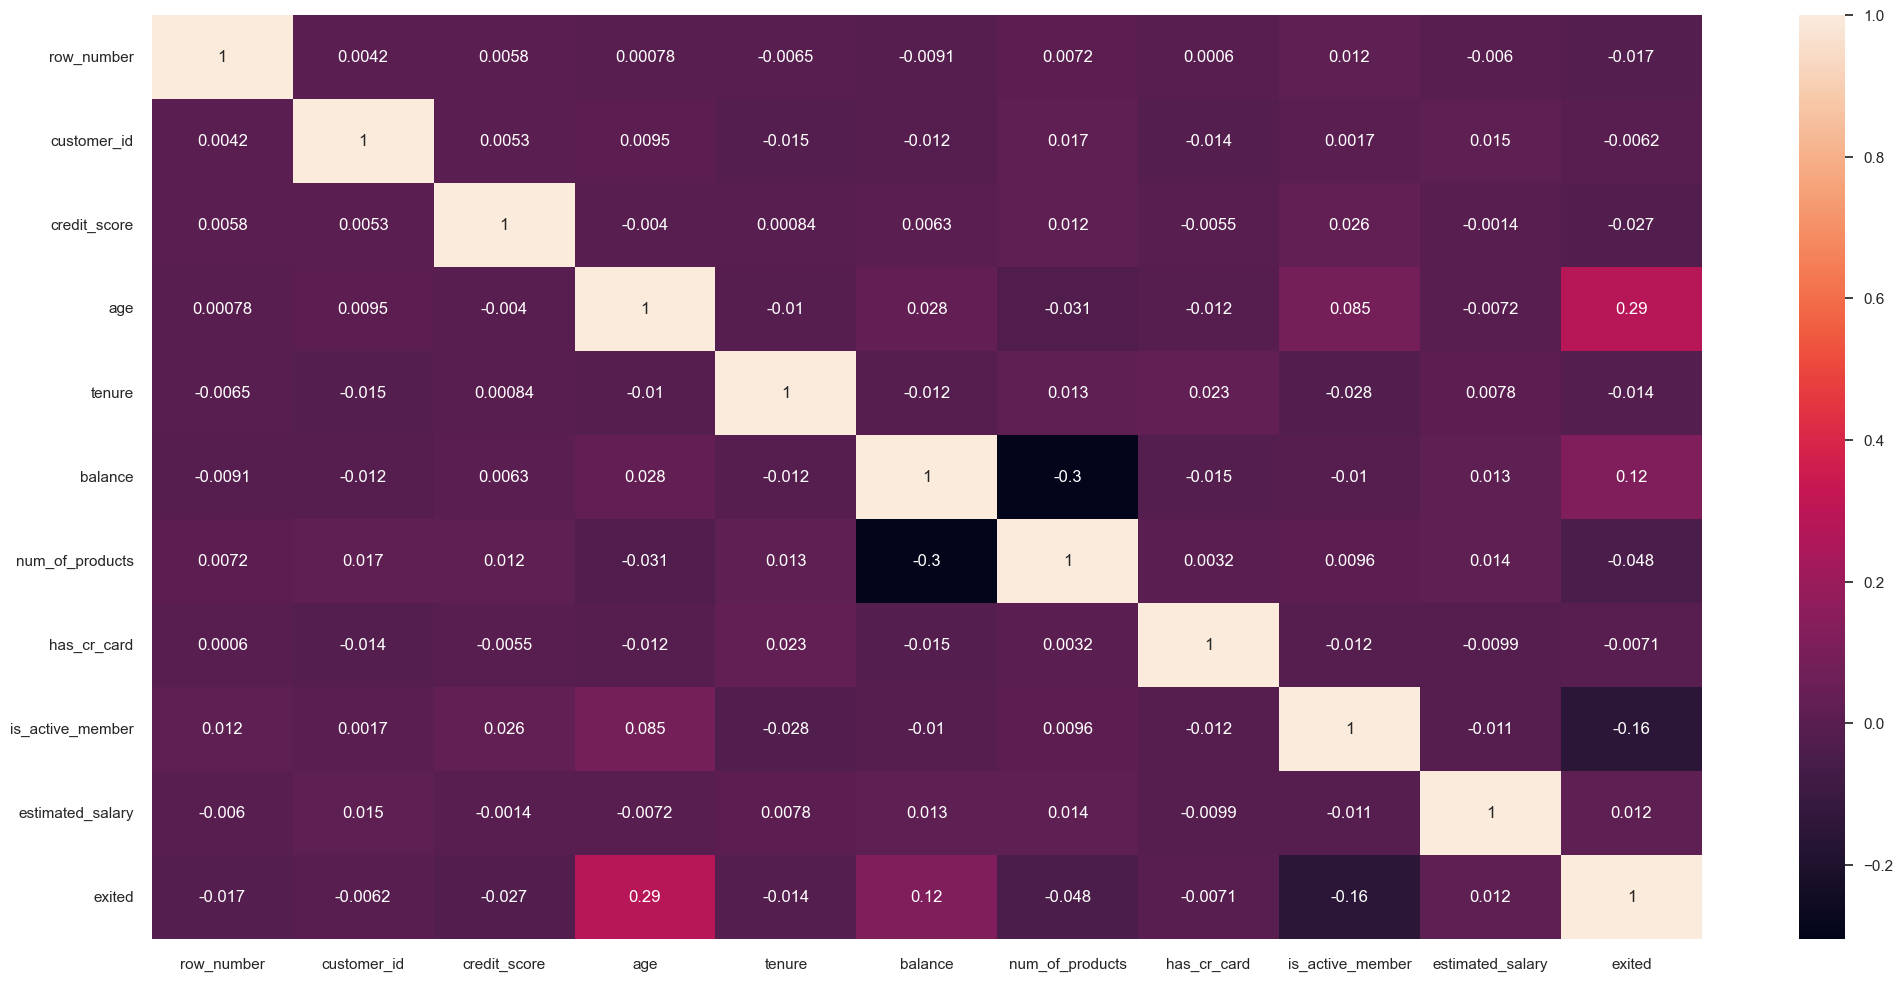

In [33]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

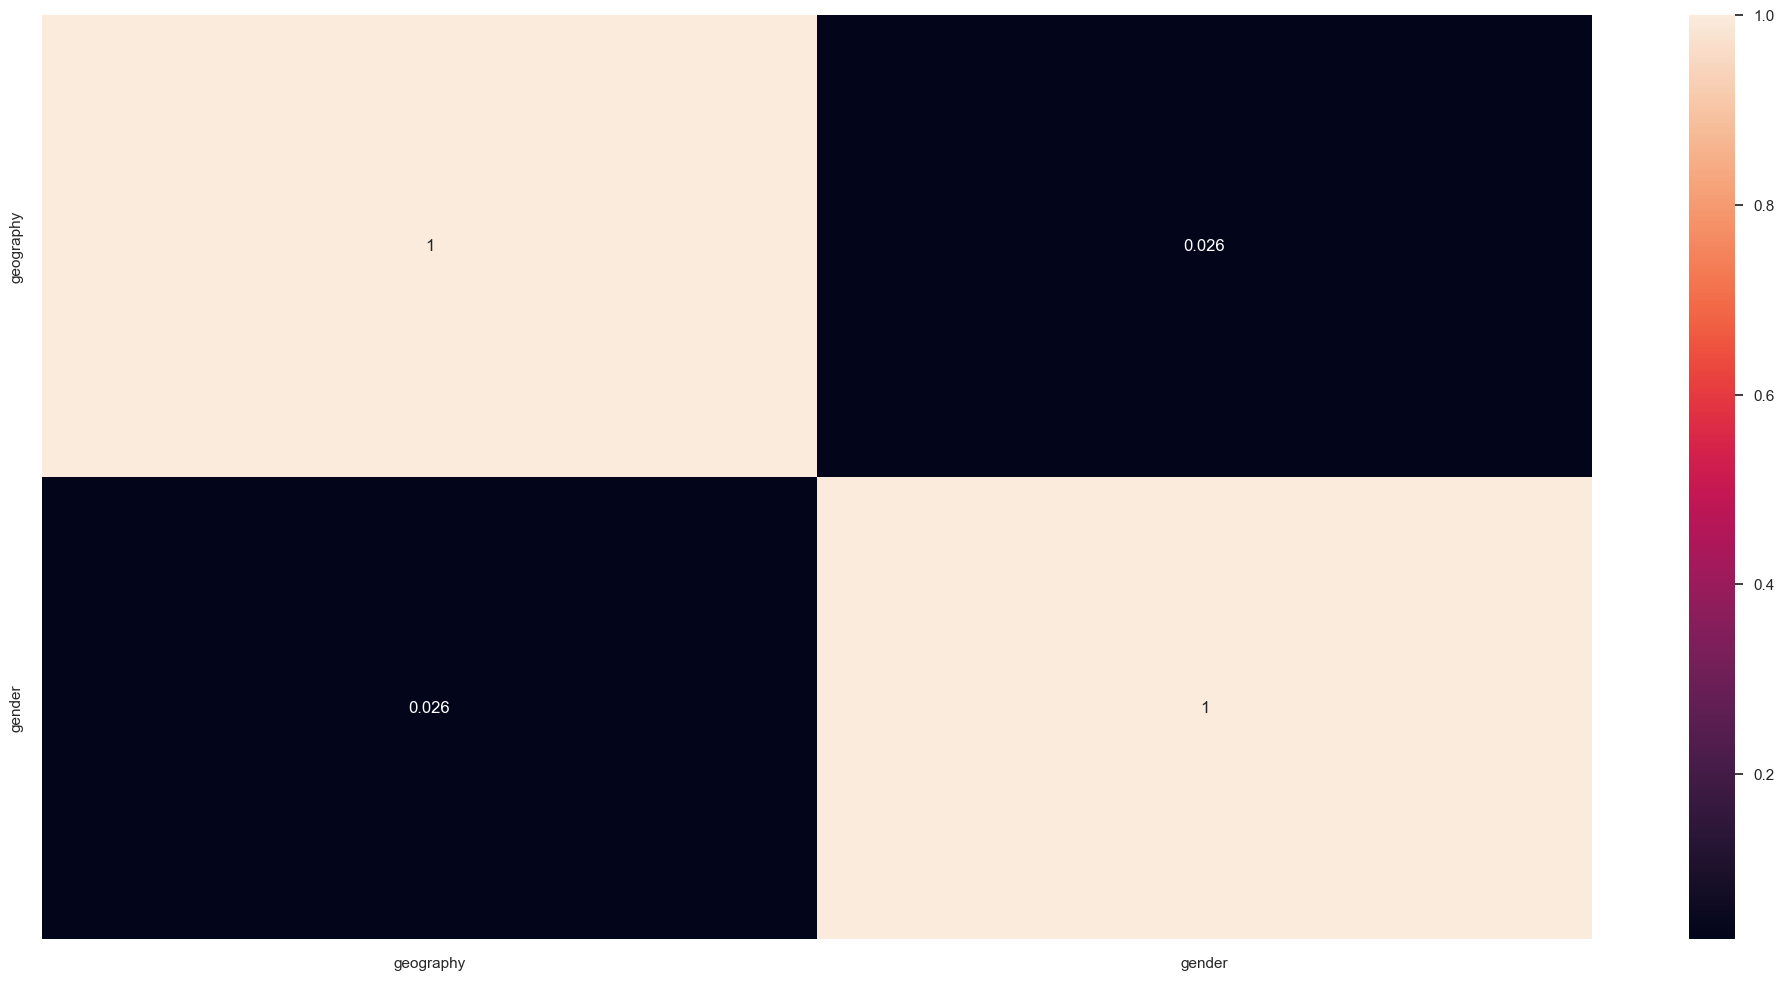

In [34]:
# Selecionando somente Dados Categóricos
cat = df4.select_dtypes(include='object')

# Calcula Cramer V
a1 = cramer_v(cat['geography'], cat['geography'])
a2 = cramer_v(cat['geography'], cat['gender'])

a3 = cramer_v(cat['gender'], cat['geography'])
a4 = cramer_v(cat['gender'], cat['gender'])

# Dataset Final
df = pd.DataFrame({'geography': [a1, a2],
                   'gender': [a3, a4],
                  })
df = df.set_index(df.columns)

# Mapa de Calor para verificar a correlação entre as variáveis categóricas
sns.heatmap(df, annot=True);

# 5.0 Data Preparation

In [35]:
df5 = df4.copy()

## 5.1 Split dataframe into training and test dataset

In [36]:
# Sorting Data and Terget
target = df5['exited'].copy()
data = df5.drop('exited', axis=1)

# Spliting Data
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=42)

df5 = pd.concat([X_train, y_train], axis=1)

print('Total Dimension:                    {}'.format(data.shape[0]))
print('Training Model Dataset Dimension:   {} ({}%)'.format(X_train.shape[0],round((X_train.shape[0]/data.shape[0])*100,2)))
print('Test Model Dataset Dimension:       {} ({}%)'.format(X_test.shape[0],round((X_test.shape[0]/data.shape[0])*100,2)))

Total Dimension:                    10000
Training Model Dataset Dimension:   8000 (80.0%)
Test Model Dataset Dimension:       2000 (20.0%)


## 5.2 Normalização

## 5.3 Rescaling

In [37]:
mms_cs = MinMaxScaler()
mms_bl = MinMaxScaler()
mms_es = MinMaxScaler()
mms_em = MinMaxScaler()
mms_te = MinMaxScaler()
mms_ag = MinMaxScaler()

# credit_score
df5['credit_score'] = mms_cs.fit_transform( df5[['credit_score']].values )

# balance
df5['balance'] = mms_bl.fit_transform(df5[['balance']].values )

# estimated_salary
df5['estimated_salary'] = mms_es.fit_transform( df5[['estimated_salary']].values )

# estimated_monthly_salary
df5['estimated_monthly_salary'] = mms_em.fit_transform( df5[['estimated_monthly_salary']].values )

# tenure
df5['tenure'] = mms_te.fit_transform( df5[['tenure']].values )

# age
df5['age'] = mms_ag.fit_transform( df5[['age']].values )

## 5.4 Transformação

### 5.4.1 Encoding

In [38]:
# gender - Label Encoding
le_gender = LabelEncoder()
df5['gender'] = le_gender.fit_transform( df5['gender'] )

# geography - Ordinal Encoding
geography_dict = {'France': 1, 'Spain': 2, 'Germany': 3}
df5['geography'] = df5['geography'].map( geography_dict )

## 5.5 Test preparation 

In [39]:
dict_preparation = {
    'RESCALING': {
        'min_max_scaler':{
            'credit_score': mms_cs,
            'balance': mms_bl,
            'estimated_salary': mms_es,
            'estimated_monthly_salary': mms_em,
            'tenure': mms_te,
            'age':    mms_ag
        }
    },
    'ENCONDING':{
        'label_encoding':{
            'gender': le_gender
        },
        'ordinal_encoding':{
            'geography':  geography_dict
        }
    }
}

In [40]:
def data_preparation(df,dict_preparation):
    
    data = df.copy()
    for type_encode in list(dict_preparation['RESCALING'].keys()):
        for att in list(dict_preparation['RESCALING'][type_encode].keys()):
            std = dict_preparation['RESCALING'][type_encode][att]
            data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['ENCONDING'].keys()):
        for att in list(dict_preparation['ENCONDING'][type_encode].keys()):
            if type_encode == 'label_encoding':
                std = dict_preparation['ENCONDING'][type_encode][att]
                data.loc[:,att] = std.transform(data[[att]].values)
            else:
                std = dict_preparation['ENCONDING'][type_encode][att]
                data.loc[:,att] = data.loc[:,att].map(std)
                
    # fillna
    data = data.fillna(0)
                
    return data

In [41]:
x_test = data_preparation(X_test, dict_preparation)

# 6.0 Feature Selection

In [43]:
df6 = df5.copy()

## 6.1 Ranking Best Features

In [44]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)

x_train_n = df6.drop('exited', axis=1)
y_train_n = df6[['exited']]
forest.fit(x_train_n, y_train_n)

# Print the feature ranking
print('Feature ranking')
df = pd.DataFrame()
for i, j in zip(x_train_n.columns, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df= pd.concat([df, aux], axis=0)

df = df.sort_values('importance',ascending=False)
df

Feature ranking


,feature,importance
0,age,0.149818
0,credit_score,0.099886
0,estimated_salary,0.095941
0,estimated_monthly_salary,0.095304
0,tenure,0.086848
0,balance,0.080142
0,num_of_products,0.075642
0,high_age,0.059221
0,is_active_member,0.051087
0,geography,0.048647


## 6.3 Boruta as Feature Selector

In [ ]:
# training and test dataset for Boruta
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = en.RandomForestClassifier( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

### 6.3.1 Best Features from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

cols_selected

In [ ]:
cols_selected_boruta = [
'age',
'balance',
'num_of_products',
'credit_score']

# 7.0 Machine Learning Model Selection

In [45]:
df7 = df6.copy()
x_train = df7.drop('exited', axis=1)

# x_train = X_train[ cols_selected_boruta ]
# x_test = X_test[ cols_selected_boruta ]

## 7.1 Logistic Regression 

In [46]:
# model
logr = LogisticRegression().fit( x_train, y_train )

# prediction
yhat_logr = logr.predict( x_test )
y_proba_logr = logr.predict_proba( x_test )

# performance
lgr_result = ml_acc('Logistic Regression', y_test, yhat_logr)

### 7.1.1 Logistic Regression Score

In [47]:
lgr_result

,Model Name,Accuracy,f1_score,Recall,Precision
0,Logistic Regression,0.8455,0.480672,0.363868,0.707921


### 7.1.2 Logistic Regression Model - Cross Validation

In [48]:
lgr_result_cv = cross_validation( 'Logistic Regression', logr, x_train, y_train, 5, verbose=False )
lgr_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV
Logistic Regression,1.0,0.018,0.839


## 7.2 Random Forest Classifier 

In [86]:
# model
rfc = RandomForestClassifier(max_depth=9, n_estimators=600, random_state=42)
rfc.fit(x_train, y_train)

# prediction
yhat_rfc = rfc.predict( x_test )
y_proba_rfc = rfc.predict_proba( x_test )

# performance
rfc_result = ml_acc('Random Forest Classifier', y_test, yhat_rfc)

### 7.2.1 Random Forest Classifier Score

In [87]:
rfc_result

,Model Name,Accuracy,f1_score,Recall,Precision
0,Random Forest Classifier,0.866,0.563518,0.440204,0.782805


### 7.2.2 Random Forest Classifier Model - Cross Validation

In [53]:
rfc_result_cv = cross_validation( 'Random Forest Classifier', rfc, x_train, y_train, 5, verbose=False )
rfc_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV
Random Forest Classifier,1.0,0.018,0.859


## 7.3 Extra Trees Classifier

In [54]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators = 600, n_jobs=-1, random_state=42)

# model fit
et_model.fit(x_train, y_train)

# model prediction
y_hat_et = et_model.predict(x_test)
y_proba_etc = et_model.predict_proba( x_test )

# performance
etc_result = ml_acc('Extra Trees Classifier', y_test, y_hat_et)

### 7.3.1 Extra Trees Classifier Score

In [55]:
etc_result

,Model Name,Accuracy,f1_score,Recall,Precision
0,Extra Trees Classifier,0.865,0.576803,0.468193,0.75102


### 7.3.2 Extra Trees Classifier Model - Cross Validation

In [56]:
etc_result_cv = cross_validation( 'Extra Trees Classifier', et_model, x_train, y_train, 5, verbose=False )
etc_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV
Extra Trees Classifier,1.0,0.018,0.851


## 7.4 XGBoost Classifier

In [57]:
n = (y_train.shape[0] - y_train.sum())/y_train.sum()
# model definition
xgb_model = xgb.XGBClassifier(n_estimators = 600 ,scale_pos_weight=n, random_state=42 )

# model fit
xgb_model.fit(x_train, y_train)

# model prediction
y_hat_xgb = xgb_model.predict(x_test)
y_proba_xgb = xgb_model.predict_proba( x_test )

# performance
xgb_result = ml_acc('XGBoost Classifier', y_test, y_hat_xgb)

### 7.4.1 XGBoost Classifier Score

In [58]:
xgb_result

,Model Name,Accuracy,f1_score,Recall,Precision
0,XGBoost Classifier,0.8155,0.604502,0.717557,0.522222


### 7.4.2 XGBoost Classifier Model - Cross Validation

In [59]:
xgb_result_cv = cross_validation( 'XGBoost Classifier', xgb_model, x_train, y_train, 5, verbose=False )
xgb_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV
XGBoost Classifier,1.0,0.018,0.799


## 7.5 KNN

In [60]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(x_train, y_train)

# model prediction
y_hat_knn = knn_model.predict(x_test)
y_proba_knn = knn_model.predict_proba( x_test )

# performance
knn_result = ml_acc('KNN', y_test, y_hat_knn)

### 7.5.1 KNN Score

In [61]:
knn_result

,Model Name,Accuracy,f1_score,Recall,Precision
0,KNN,0.85,0.486301,0.361323,0.743455


### 7.5.2 KNN Model - Cross Validation

In [62]:
knn_result_cv = cross_validation( 'KNN', knn_model, x_train, y_train, 5, verbose=False )
knn_result_cv

,Precision @k - CV,Recall @k - CV,Accuracy - CV
KNN,0.8,0.015,0.845


## 7.6 Compare Model's Performance

### 7.6.1. Single Performance

In [63]:
modelling_result = pd.concat( [lgr_result, rfc_result, etc_result, xgb_result, knn_result] )
modelling_result.sort_values('Accuracy', ascending=False)

,Model Name,Accuracy,f1_score,Recall,Precision
0,Random Forest Classifier,0.8660,0.563518,0.440204,0.782805
0,Extra Trees Classifier,0.8650,0.576803,0.468193,0.751020
0,KNN,0.8500,0.486301,0.361323,0.743455
0,Logistic Regression,0.8455,0.480672,0.363868,0.707921
0,XGBoost Classifier,0.8155,0.604502,0.717557,0.522222


### 7.6.2. Real Performance - Cross Validation

In [64]:
modelling_result_cv = pd.concat( [lgr_result_cv, rfc_result_cv, etc_result_cv, xgb_result_cv, knn_result_cv] )
modelling_result_cv.sort_values('Accuracy - CV', ascending=False)

,Precision @k - CV,Recall @k - CV,Accuracy - CV
Random Forest Classifier,1.0,0.018,0.859
Extra Trees Classifier,1.0,0.018,0.851
KNN,0.8,0.015,0.845
Logistic Regression,1.0,0.018,0.839
XGBoost Classifier,1.0,0.018,0.799


# 8.0 Hyperparameter Fine Tuning

In [65]:
df8 = df7.copy()

## 8.1 Grid Search Model

### 8.1.1 Random Forest Classifier

In [77]:
rf_params = {
    'n_estimators': [100, 300, 500, 600],
    #'max_features': ['sqrt',0.5],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_samples_leaf': [1, 3, 5, 7],
    #"bootstrap":[True,False],
    "criterion":['gini','entropy']
}
clf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
grid.fit(x_train, y_train)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 500}
Accuracy:0.865874089444746


### 8.1.2 Final Model

In [89]:
# model
rfc_tuned = RandomForestClassifier(max_depth=15, n_estimators=500, min_samples_leaf=3, criterion='entropy', random_state=42)
rfc_tuned.fit(x_train, y_train)

# prediction
yhat_rfc_tuned = rfc_tuned.predict( x_test )

# performance
rfc_tuned_result = ml_acc('Random Forest Classifier', y_test, yhat_rfc_tuned)
rfc_tuned_result

,Model Name,Accuracy,f1_score,Recall,Precision
0,Random Forest Classifier,0.866,0.571885,0.455471,0.76824


# 9.0 Results Interpretation

In [115]:
df9 = df8.copy()

## 9.1 Graphs Visualization

### 9.1.1 ROC AUC Curve

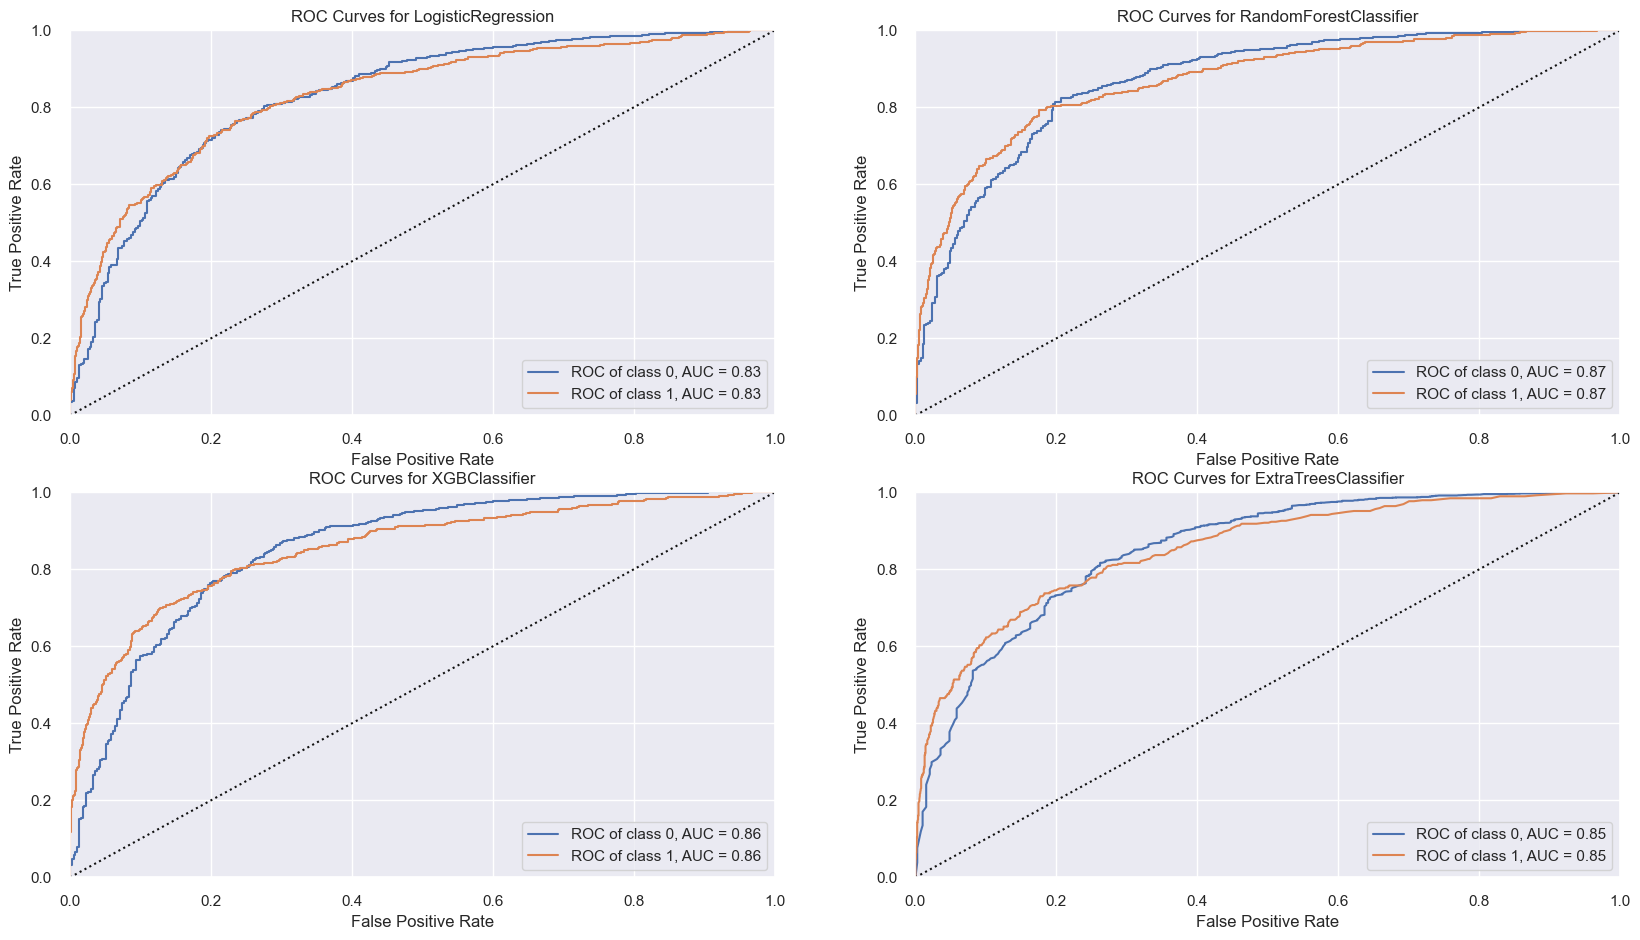

In [66]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 11))

viz = ROCAUC(logr, iso_f1_curves=True, micro=False, macro=False, ax=ax1)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

viz = ROCAUC(rfc, iso_f1_curves=True, micro=False, macro=False, ax=ax2)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

viz = ROCAUC(xgb_model, iso_f1_curves=True, micro=False, macro=False, ax=ax3)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

viz = ROCAUC(et_model, iso_f1_curves=True, micro=False, macro=False, ax=ax4)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

### 9.1.2 Confusion Matrix Visualization

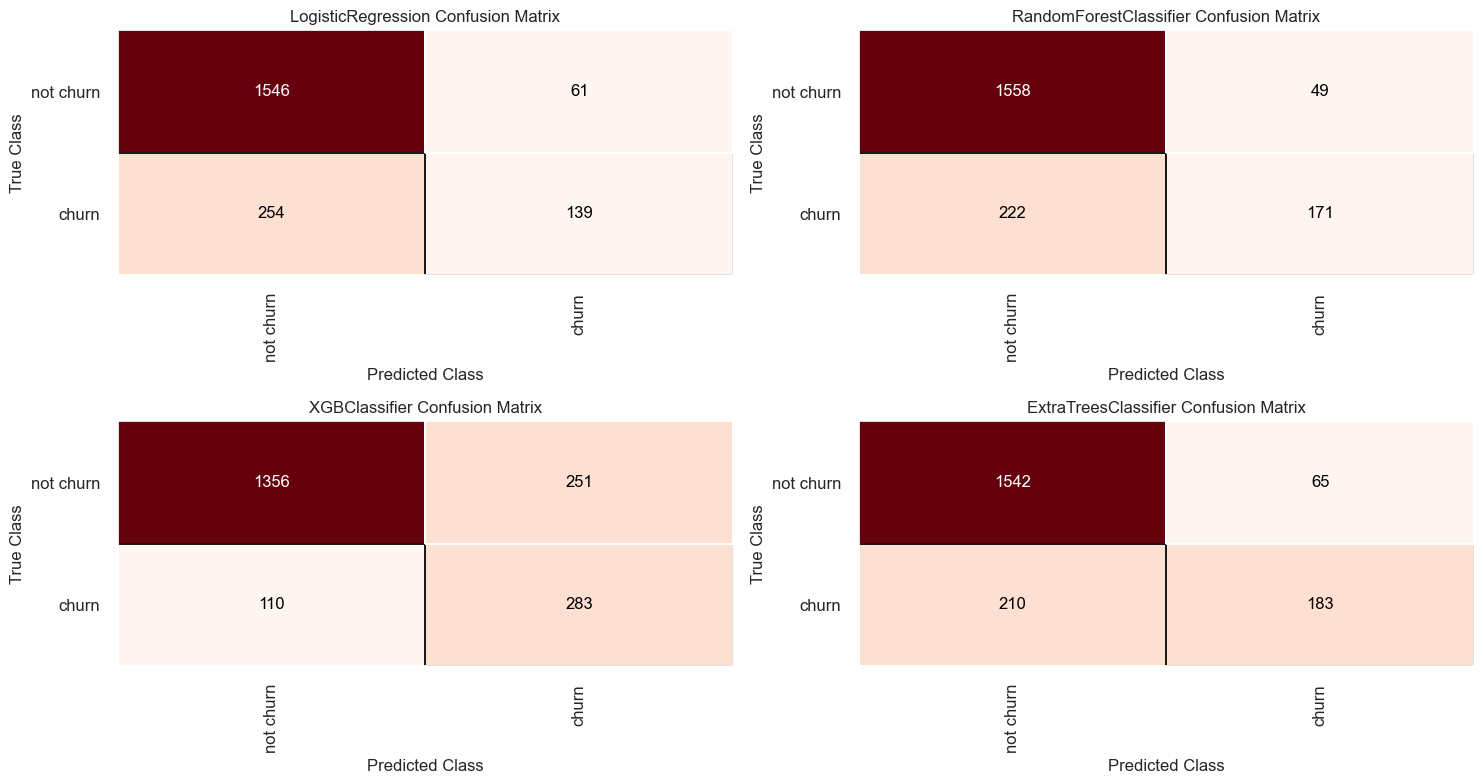

In [71]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15, 8))

visualizer = ConfusionMatrix(logr, classes=['not churn', 'churn'], support=True, ax=ax1, cmap='Reds')
visualizer.fit(x_train, y_train)  
visualizer.score(x_test, y_test)  
g = visualizer.finalize()

visualizer = ConfusionMatrix(rfc, classes=['not churn', 'churn'], support=True, ax=ax2, cmap='Reds')
visualizer.fit(x_train, y_train)  
visualizer.score(x_test, y_test)  
g = visualizer.finalize()

visualizer = ConfusionMatrix(xgb_model, classes=['not churn', 'churn'], support=True, ax=ax3, cmap='Reds')
visualizer.fit(x_train, y_train)  
visualizer.score(x_test, y_test)  
g = visualizer.finalize()

visualizer = ConfusionMatrix(et_model, classes=['not churn', 'churn'], support=True, ax=ax4, cmap='Reds')
visualizer.fit(x_train, y_train)  
visualizer.score(x_test, y_test)  
g = visualizer.finalize()

### 9.1.3 PrecisionRecall Curve

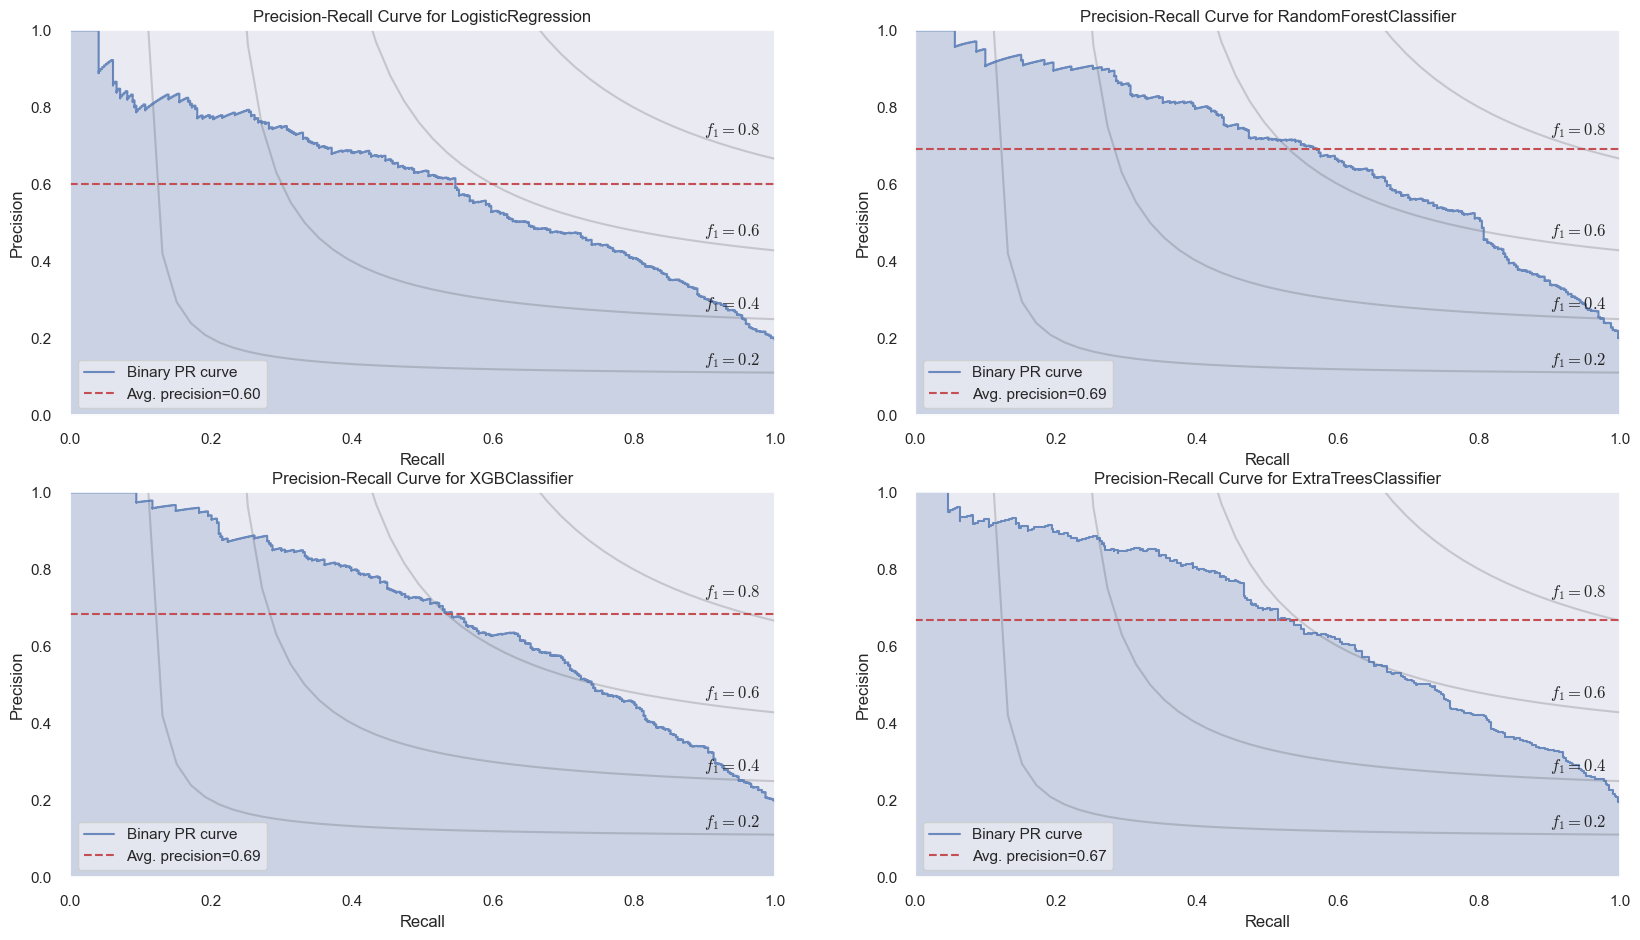

In [118]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 11))

viz = PrecisionRecallCurve(logr, iso_f1_curves=True, ax=ax1)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

viz = PrecisionRecallCurve(rfc, iso_f1_curves=True, ax=ax2)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

viz = PrecisionRecallCurve(xgb_model, iso_f1_curves=True, ax=ax3)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

viz = PrecisionRecallCurve(et_model, iso_f1_curves=True, ax=ax4)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.finalize()

### 9.1.4 Lift Curve

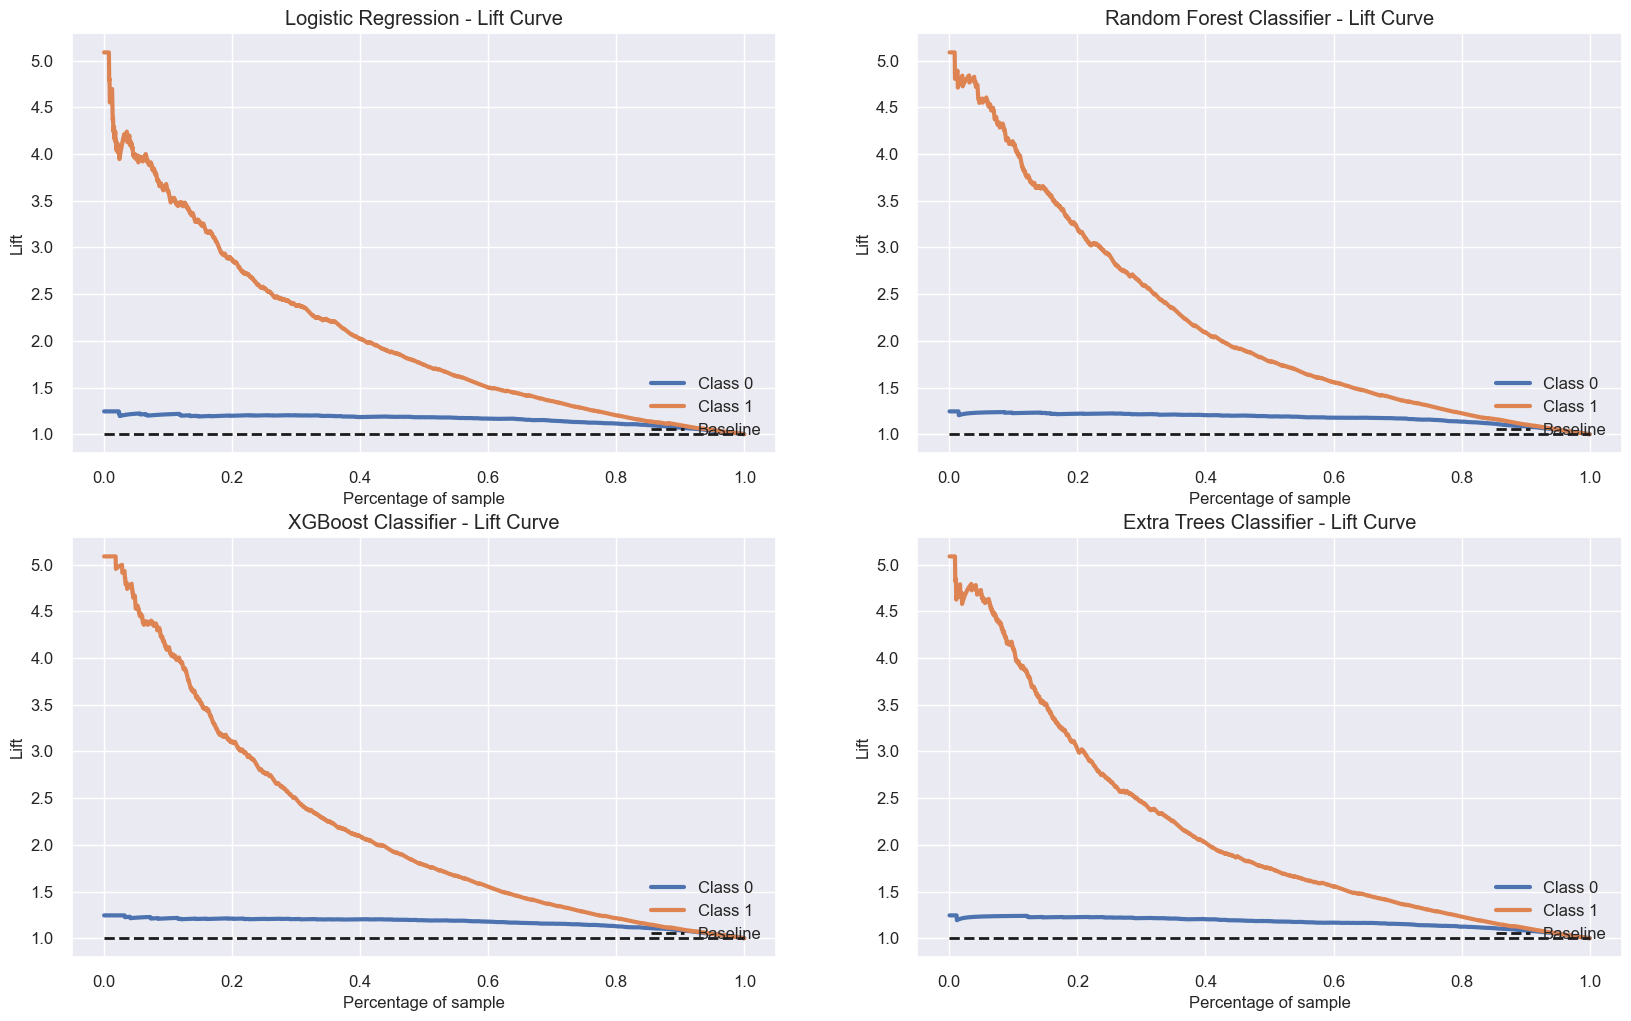

In [119]:
#Plot Lift Curve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

plot_lift_curve(y_test, y_proba_logr, title='Logistic Regression - Lift Curve', ax=ax1)

plot_lift_curve(y_test, y_proba_rfc, title='Random Forest Classifier - Lift Curve', ax=ax2)

plot_lift_curve(y_test, y_proba_xgb, title='XGBoost Classifier - Lift Curve', ax=ax3) 

plot_lift_curve(y_test, y_proba_etc, title='Extra Trees Classifier - Lift Curve',ax=ax4)  ;

### 9.1.5 Cumulative Gain Curve 

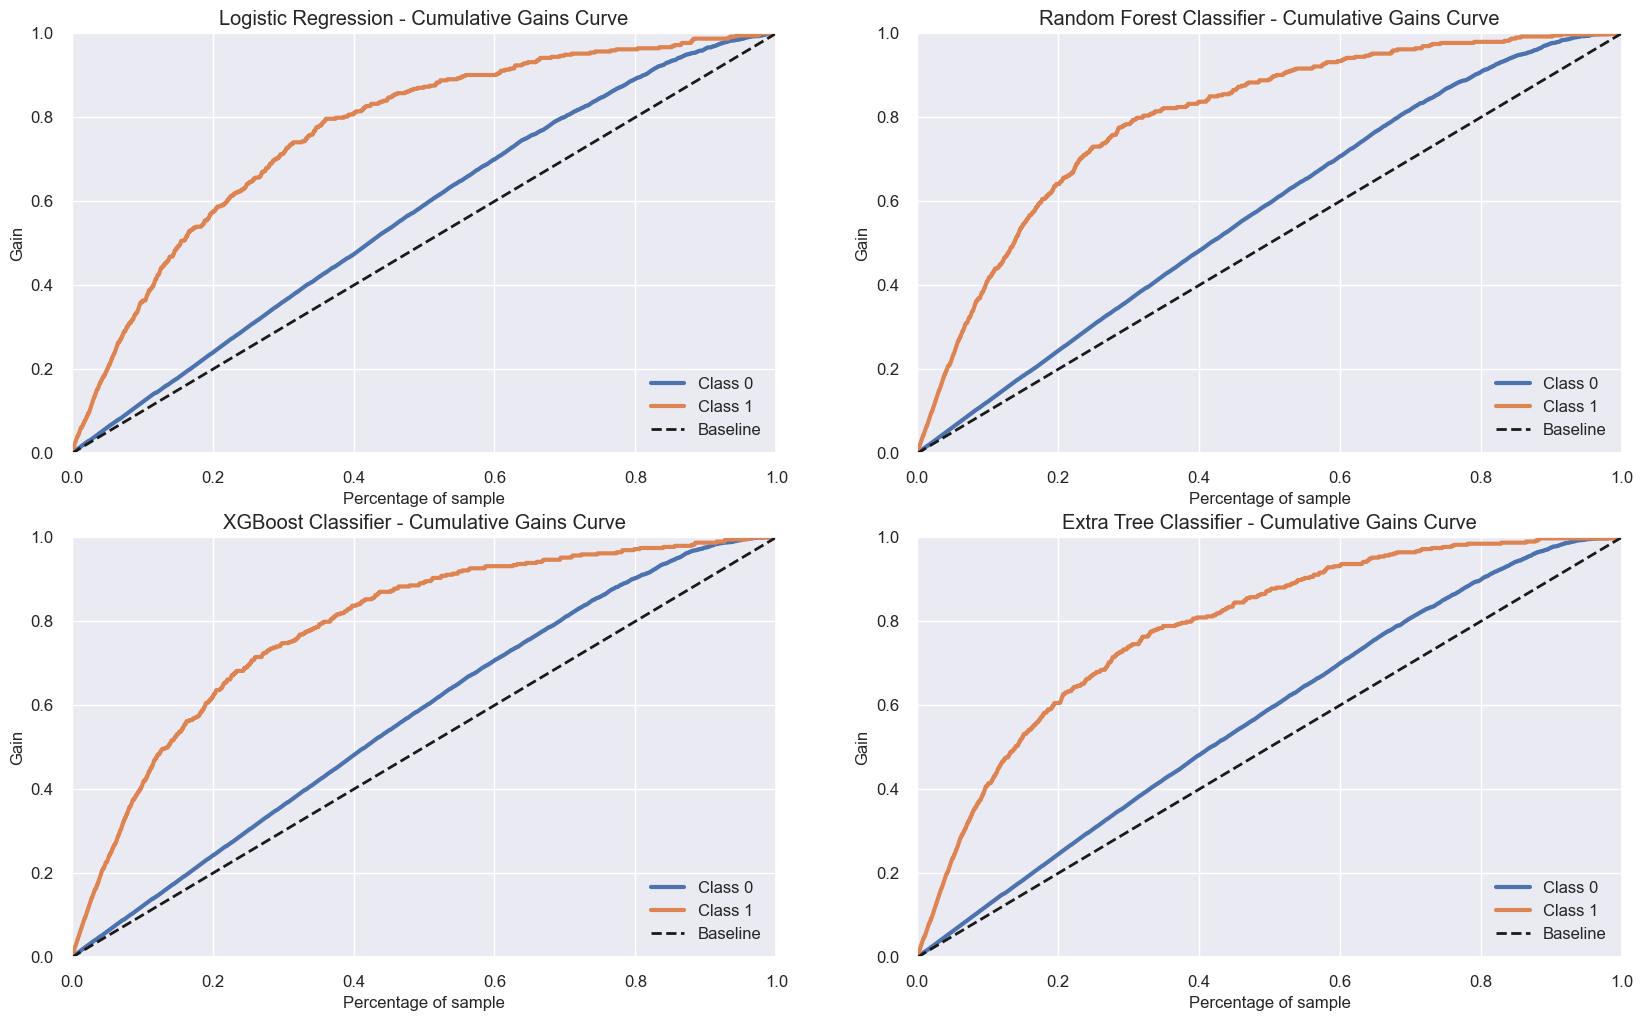

In [120]:
#Plot Cumulative Gain Curve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

plot_cumulative_gain(y_test, y_proba_logr, title='Logistic Regression - Cumulative Gains Curve', ax=ax1)

plot_cumulative_gain(y_test, y_proba_rfc, title='Random Forest Classifier - Cumulative Gains Curve', ax=ax2)

plot_cumulative_gain(y_test, y_proba_xgb, title='XGBoost Classifier - Cumulative Gains Curve', ax=ax3) 

plot_cumulative_gain(y_test, y_proba_etc, title='Extra Tree Classifier - Cumulative Gains Curve',ax=ax4)  ;

## 9.2 Business Performance

O orçamento para o plano de ação para reduzir o churn rate de clientes é de S 10.000,00. 
As equipes de negócios e marketing trabalharam juntas em um estudo e chegaram a três opções. 
Cabe agora à equipe de Data Science escolher qual opção maximizará o ROI - Return on Investment. A estratégia é fazer uma simulação no dataset com todas as três opções e escolher a opção que dá os melhores resultados.
A estratégia é fazer uma simulação no conjunto de dados com todas as três opções e escolher a opção que dá os melhores resultados.
A receita de clientes é calculada da seguinte forma:
 - Clientes com salário abaixo da média: Retorna 3% do salário estimado
 - Clientes com salário acima da média: Retorna 5% do salário estimado 
    
A média salarial estimada é de S 100.090,00. Por exemplo, se o salário anual estimado do cliente for de S 100.000,00, o banco terá um retorno anual de S 100.000,00 x 5% = S 5.000,00 por cliente.

### 9.2.1 Cupom de desconto no valor de R$ 100,00

Com um desconto de 100 e um orçamento de 10.000,00, os 100 primeiros clientes com maiores probabilidades receberiam o cupom. Dos 100 maiores clientes, 90% deles eram True Churns e 10% eram False Churns. Quando se trata de Salários Estimados, 52% deles estavam acima da média e 48% deles estavam abaixo da média.

Resultados financeiros: 

- Caso todos os clientes propensos ao churn forem recuperados: S 311058.0
- Clientes que não tendem ao churn (False Churn Clients) - Prejuízo: S 1000

Análise dos possíveis cenários: 

- Pessimistic - Recuperados: S 217741.0
- Realistic - Recuperados: S 248846.0
- Optmistic - Recuperados: S 279952.0
- Mean of scenarios - Recuperados: S 217741.0

In [121]:
y_prob_rfc = pd.DataFrame(y_proba_rfc) 

y_test_rfc = y_test.to_frame() 

bal = df_raw[['EstimatedSalary']]

exited_bal = pd.concat((y_test_rfc, bal), axis=1)

exited_bal.reset_index(drop=True, inplace=True)

pred = pd.concat((exited_bal, y_prob_rfc), axis=1)

pred.drop([0], axis=1, inplace=True)

pred.sort_values(by=1, inplace=True, ascending=False) 

top_100 = pred.head(100) 

a = top_100['exited'].value_counts(normalize=True)*100

a.to_frame()

,exited
1.0,90.0
0.0,10.0


In [122]:
false_churn = top_100['exited'].value_counts()

false_churn.to_frame()

,exited
1.0,90
0.0,10


In [123]:
mean = df_raw['EstimatedSalary'].mean().round()

top_100['above_average'] = top_100['EstimatedSalary']

top_100['above_average'] = top_100['above_average'].apply(lambda x: 'yes' if x >= mean else 'no')

a = top_100.pivot_table(values='exited', columns='above_average', aggfunc='count')

a

above_average,no,yes
exited,48,52


In [124]:
true_100 = top_100[top_100['exited'] == 1]

true_100['100_return'] = true_100['EstimatedSalary']

true_100['100_return'] = true_100['100_return'].apply(lambda x: x*0.03 if x >= mean else x*0.05)

return_100 = (true_100['100_return'].sum()).round()

waste_100 = false_churn[0] * 100

print('Caso todos os clientes propensos ao churn forem recuperados: $', return_100)
print('Clientes que não tendem ao churn (Prejuízo): $',waste_100)

Caso todos os clientes propensos ao churn forem recuperados: $ 311058.0
Clientes que não tendem ao churn (Prejuízo): $ 1000


In [125]:
#Scenario analysis

#Pessimistic
p_recovered_100 = (return_100 * 0.7).round()
print('Pessimistic - Recuperados: $', p_recovered_100)

#Realistic
r_recovered_100 = (return_100 * 0.8).round()
print('Realistic - Recuperados: $', r_recovered_100)

#Optmistic
o_recovered_100 = (return_100 * 0.9).round()
print('Optmistic - Recuperados: $', o_recovered_100)

#Mean
mean_scenarios_100 = ((p_recovered_100 + p_recovered_100 + p_recovered_100) / 3).round()
print('Mean of scenarios - Recuperados: $', mean_scenarios_100)

Pessimistic - Recuperados: $ 217741.0
Realistic - Recuperados: $ 248846.0
Optmistic - Recuperados: $ 279952.0
Mean of scenarios - Recuperados: $ 217741.0


### 9.2.2 Cupom de desconto no valor de R$ 50,00

Com um desconto de 50 e um orçamento de 10.000,00, os 200 maiores clientes com maiores probabilidades receberiam o cupom. Dos 200 principais clientes, 94% deles eram True Churns e 6% eram False Churns. Quanto aos Salários Estimados, 59,5% deles ficaram acima da média e 40,5% deles ficaram abaixo da média, o mesmo percentual dos 100 maiores clientes.

Resultados financeiros:

- Caso todos os clientes propensos ao churn forem recuperados: S 546058.0
- Clientes que não tendem ao churn (False Churn Clients) - Prejuízo: S 1950

Análise dos possíveis cenários: 

- Pessimistic - Recuperados: S 218423.0
- Realistic - Recuperados: S 273029.0
- Optmistic - Recuperados: S 327635.0
- Mean of scenarios - Recuperados: S 273029.0

In [136]:
top_200 = pred.head(200) 

a2 = top_200['exited'].value_counts(normalize=True)*100

a2.to_frame()

,exited
1.0,80.5
0.0,19.5


In [137]:
false_churn_200 = top_200['exited'].value_counts()

false_churn_200.to_frame()

,exited
1.0,161
0.0,39


In [139]:
top_200['above_average'] = top_200['EstimatedSalary']

top_200['above_average'] = top_200['above_average'].apply(lambda x: 'yes' if x >= mean else 'no')

a3 = top_200.pivot_table(values='exited', columns='above_average', aggfunc='count')

a3

above_average,no,yes
exited,100,100


In [140]:
true_200 = top_200[top_200['exited'] == 1]

true_200['200_return'] = true_200['EstimatedSalary']

true_200['200_return'] = true_200['200_return'].apply(lambda x: x*0.03 if x >= mean else x*0.05)

return_200 = (true_200['200_return'].sum()).round()

waste_200 = false_churn_200[0] * 50

print('Caso todos os clientes propensos ao churn forem recuperados: $', return_200)
print('Clientes que não tendem ao churn (Prejuízo): $',waste_200)

Caso todos os clientes propensos ao churn forem recuperados: $ 546058.0
Clientes que não tendem ao churn (Prejuízo): $ 1950


In [141]:
#Scenario analysis

#Pessimistic
p_recovered_200 = (return_200 * 0.4).round()
print('Pessimistic - Recuperados: $', p_recovered_200)

#Realistic
r_recovered_200 = (return_200 * 0.5).round()
print('Realistic - Recuperados: $', r_recovered_200)

#Optmistic
o_recovered_200 = (return_200 * 0.6).round()
print('Optmistic - Recuperados: $', o_recovered_200)

#Mean
mean_scenarios_200 = ((p_recovered_200 + r_recovered_200 + o_recovered_200) / 3).round()
print('Mean of scenarios - Recuperados: $', mean_scenarios_200)

Pessimistic - Recuperados: $ 218423.0
Realistic - Recuperados: $ 273029.0
Optmistic - Recuperados: $ 327635.0
Mean of scenarios - Recuperados: $ 273029.0


### 9.2.3 Cupom de desconto no valor de R$ 25,00

Com um desconto de 50 e um orçamento de 10.000,00, os 400 maiores clientes com maiores probabilidades receberiam o cupom. Dos 400 maiores clientes, 82,25% deles eram True Churns e 17,75% eram False Churns. Quanto aos Salários Estimados, 59,25% deles ficaram acima da média e 40,75% deles ficaram abaixo da média.

Resultados financeiros:

- Caso todos os clientes propensos ao churn forem recuperados: S 853548.0
- Clientes que não tendem ao churn (False Churn Clients) - Prejuízo: S 3700

Análise dos possíveis cenários: 

- Pessimistic - Recuperados: S 163817.0
- Realistic - Recuperados: S 218423.0
- Optmistic - Recuperados: S 273029.0
- Mean of scenarios - Recuperados: S 218423.0

In [142]:
top_400 = pred.head(400) 

a4 = top_400['exited'].value_counts(normalize=True)*100

a4.to_frame()

,exited
1.0,63.0
0.0,37.0


In [143]:
false_churn_400 = top_400['exited'].value_counts()

false_churn_400.to_frame()

,exited
1.0,252
0.0,148


In [145]:
top_400['above_average'] = top_400['EstimatedSalary']

top_400['above_average'] = top_400['above_average'].apply(lambda x: 'yes' if x>=mean else 'no')

a5 = top_400.pivot_table(values='exited', columns='above_average', aggfunc='count')

a5

above_average,no,yes
exited,215,185


In [147]:
true_400 = top_400[top_400['exited'] == 1]

true_400['400_return'] = true_400['EstimatedSalary']

true_400['400_return'] = true_400['400_return'].apply(lambda x: x*0.03 if x>=mean else x*0.05)

return_400 = (true_400['400_return'].sum()).round()

waste_400 = false_churn_400[0] * 25

print('Caso todos os clientes propensos ao churn forem recuperados: $', return_400)
print('Clientes que não tendem ao churn (Prejuízo): $',waste_400)

Caso todos os clientes propensos ao churn forem recuperados: $ 853548.0
Clientes que não tendem ao churn (Prejuízo): $ 3700


In [148]:
#Scenario analysis

#Pessimistic
p_recovered_400 = (return_200 * 0.3).round()
print('Pessimistic - Recuperados: $', p_recovered_400)

#Realistic
r_recovered_400 = (return_200 * 0.4).round()
print('Realistic - Recuperados: $', r_recovered_400)

#Optmistic
o_recovered_400 = (return_200 * 0.5).round()
print('Optmistic - Recuperados: $', o_recovered_400)

#Mean
mean_scenarios_400 = ((p_recovered_400 + r_recovered_400 + o_recovered_400) / 3).round()
print('Mean of scenarios - Recuperados: $', mean_scenarios_400)

Pessimistic - Recuperados: $ 163817.0
Realistic - Recuperados: $ 218423.0
Optmistic - Recuperados: $ 273029.0
Mean of scenarios - Recuperados: $ 218423.0


# 10.0 Deploy Model to Production

In [ ]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '/Users/luishmq/Documents/repos/churn_prediction/churn_clients_predict/models/model_churn.pkl', 'wb' ) )

In [ ]:
class ChurnPrediction():
    def __init__(self):
        self.home_path = '/Users/luishmq/Documents/repos/churn_prediction/churn_clients_predict/'
        self.annual_premium_scaller      = pickle.load(open(self.path + 'src\\features\\annual_premium_scaller.pkl'))
        self.age_scaler                  = pickle.load(open(self.path + 'src\\features\\age_scaler.pkl'))
        self.vintage_scaler              = pickle.load(open(self.path + 'src\\features\\vintage_scaler.pkl'))
        self.gender_scaler               = pickle.load(open(self.path + 'src\\features\\gender_scaler.pkl'))
        self.region_code_scaler          = pickle.load(open(self.path + 'src\\features\\region_code_scaler.pkl'))
        self.policy_sales_channel_scaler = pickle.load(open(self.path + 'src\\features\\policy_sales_channel_scaler.pkl'))             
    